Google Speech Command Dataset: https://www.kaggle.com/datasets/mok0na/speech-commands-v002


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
myDrive_path = 'gdrive/Shareddrives/'

Mounted at /content/gdrive


In [ ]:
ACC_train = []
ACC_test = []
LOSS_train = []
LOSS_test = []

# Part 1: Dataloader

In [ ]:
# prepare_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import librosa   #for audio processing
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def load_data(train_audio_path):
    
    #train_audio_path = path

    #labels=os.listdir(train_audio_path)
    
    labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", 
          "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    #print(labels)

    all_wave = []
    all_label = []
    for label in labels:
        print(label)
        waves = [f for f in os.listdir(train_audio_path + '/'+ label+ '/') if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(samples, sample_rate, 8000)
            if(len(samples)== 8000) : 
                all_wave.append(samples)
                all_label.append(label)


    
    le = LabelEncoder()
    y=le.fit_transform(all_label)
    classes= list(le.classes_)


    y=np_utils.to_categorical(y, num_classes=len(labels))

    all_wave = np.array(all_wave).reshape(-1,8000,1)

    return np.array(all_wave), np.array(y)


def get_dataloader(x,y,batch_size=32):
    x = x.transpose(0,2,1)
    labels = np.argmax(y,axis=1)

    x_tr, x_val, y_tr, y_val = train_test_split(x,labels,
                            stratify=labels,test_size=0.2,random_state=777,shuffle=True)

    print("Training Data: ",x_tr.shape)
    print("Validating Data: ", x_val.shape)

    features_train = torch.from_numpy(x_tr).float()
    targets_train = torch.from_numpy(y_tr).long()

    features_val = torch.from_numpy(x_val).float()
    targets_val = torch.from_numpy(y_val).long()

    train_set = TensorDataset(features_train,targets_train)
    val_set = TensorDataset(features_val,targets_val)

    train_loader = DataLoader(train_set,batch_size,True)
    val_loader = DataLoader(val_set,batch_size,False)

    print(np.unique(labels))
    
    return train_loader, val_loader

In [ ]:
import torch, argparse
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

    
LEARNING_RATE = 0.001
BATCH_SIZE = 100         
N_EPOCHS = 70           
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
x, y = load_data('gdrive/Shareddrives/CS172B Project/GoogleSpeech/speech_commands_v0.02')
train_loader, val_loader = get_dataloader(x,y,batch_size=BATCH_SIZE)

yes
no
up
down
left
right
on
off
stop
go
zero
one
two
three
four
five
six
seven
eight
nine
Training Data:  (56482, 1, 8000)
Validating Data:  (14121, 1, 8000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


# Part 2: CNN Model

In [ ]:
# model
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

class KWS_CNN(nn.Module):
    def __init__(self, drop_out_rate=0.3):
        super(KWS_CNN,self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=13,stride=1)
        self.dropout1 = nn.Dropout(drop_out_rate) 
    
        self.conv2 = nn.Conv1d(in_channels=8,out_channels=16,kernel_size=11,stride=1)
        self.dropout2 = nn.Dropout(drop_out_rate)
        
        self.conv3 = nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1)
        self.dropout3 = nn.Dropout(drop_out_rate)
        
        self.conv4 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=7,stride=1)
        self.dropout4 = nn.Dropout(drop_out_rate)
        
        
        self.fc1 = nn.Linear(6080, 256)
        self.dropout5 = nn.Dropout(drop_out_rate)
        self.fc2 = nn.Linear(256,128)
        self.dropout6 = nn.Dropout(drop_out_rate)
        self.fc3 = nn.Linear(128, 31)
        
    def forward(self, x):
        print(f"input size: {x.shape}")
        x = F.max_pool1d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool1d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)
        
        x = F.max_pool1d(F.relu(self.conv3(x)),kernel_size=3)
        x = self.dropout3(x)
        
        x = F.max_pool1d(F.relu(self.conv4(x)),kernel_size=3)
        x = self.dropout4(x)
        print(f"Before flatten: {x.shape}")  

        x = F.relu(self.fc1(x.reshape(-1,6080)))
        x = self.dropout5(x)
        print(f"Before shrink: {x.shape}")

        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        print(f"output size: {x.shape}")
        return x 

In [ ]:
print(x.shape)
x = x[:50000,:,:]
y = y[:50000,:]
print(y.shape)
print(len(train_loader.dataset))
print(len(val_loader.dataset))
train_loader, val_loader = get_dataloader(x,y,batch_size=BATCH_SIZE)

(3756, 12, 16, 1)
(3756, 1)
3004
752
Training Data:  (3004, 1, 12, 16)
Validating Data:  (752, 1, 12, 16)
[0]


In [ ]:
# train_config
import torch,os,sys,datetime,time
from tqdm import tqdm
import torch.optim as optim

best_acc=0

def train(net,trainloader,optim,criterion,epoch,device):
    print("Training")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    
    iterator = tqdm(trainloader)
    
    for inputs,targets in iterator:
        
        inputs,targets = inputs.to(device), targets.to(device)
        
        optim.zero_grad()
        outputs = net(inputs)
        print(f"outputs size is {outputs}")
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1,train_loss/len(trainloader),
                                            total_correct*100/total))
    ACC_train.append(total_correct*100/total)
    LOSS_train.append(train_loss/len(trainloader))

    
def test(net,testloader,optim,criterion,epoch,device):
    global best_acc
    print("validation")
    net.eval()
    test_loss,total,total_correct = 0,0,0
    
    iterator = tqdm(testloader)
    
    for inputs, targets in iterator:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    # Save checkpoint when best model
    acc = 100. * total_correct / total
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch+1, test_loss, acc))
    ACC_test.append(acc)
    LOSS_test.append(test_loss/100)
    

    if acc > best_acc:
        print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        state = {
                'net':net,
                'acc':acc,
                'epoch':epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+'model.t7')
        best_acc = acc
        
    return best_acc

# Part 3: Train & Test

1. Test the best drop out rate

In [ ]:
def plot_performance(Atrain, Atest, Ltrain, Ltest, note):
  
  Epoch = [i for i in range(len(Atrain))]

  plt.plot(Epoch, Atrain, label="Train Accuracy")
  plt.plot(Epoch, Atest, label="Test Accuracy")

  plt.title("Performance"+note)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  leg = plt.legend(loc='lower right')
  plt.show()

  plt.plot(Epoch, Ltrain, label="Train Loss")
  plt.plot(Epoch, Ltest, label="Test Loss")
  plt.title("Performance"+note)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  leg = plt.legend(loc='upper right')

  plt.show()

In [ ]:
# hyper-parameter testing
DROPOUT = [0.3, 0.4, 0.5, 0.6]
ACC_DROPOUT = []

KWS_CNN(
  (conv1): Conv1d(1, 8, kernel_size=(13,), stride=(1,))
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(11,), stride=(1,))
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6080, out_features=256, bias=True)
  (dropout5): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout6): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=31, bias=True)
)
Training


100%|██████████| 400/400 [00:07<00:00, 51.27it/s]


Epoch: [1]  loss: [2.67] Accuracy [9.07] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.69it/s]



Validation Epoch #1			Loss: 231.3752 Acc@1: 18.98%
Saving Best model...			Top1 = 18.98%
Training


100%|██████████| 400/400 [00:07<00:00, 54.09it/s]


Epoch: [2]  loss: [1.93] Accuracy [31.91] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.52it/s]



Validation Epoch #2			Loss: 156.3857 Acc@1: 45.55%
Saving Best model...			Top1 = 45.55%
Training


100%|██████████| 400/400 [00:07<00:00, 57.09it/s]


Epoch: [3]  loss: [1.53] Accuracy [46.41] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.39it/s]



Validation Epoch #3			Loss: 127.9495 Acc@1: 56.78%
Saving Best model...			Top1 = 56.78%
Training


100%|██████████| 400/400 [00:07<00:00, 54.72it/s]


Epoch: [4]  loss: [1.35] Accuracy [53.08] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.31it/s]



Validation Epoch #4			Loss: 112.7816 Acc@1: 62.34%
Saving Best model...			Top1 = 62.34%
Training


100%|██████████| 400/400 [00:08<00:00, 49.43it/s]


Epoch: [5]  loss: [1.21] Accuracy [57.98] 
validation


100%|██████████| 100/100 [00:01<00:00, 87.43it/s]



Validation Epoch #5			Loss: 98.6348 Acc@1: 68.04%
Saving Best model...			Top1 = 68.04%
Training


100%|██████████| 400/400 [00:07<00:00, 52.68it/s]


Epoch: [6]  loss: [1.07] Accuracy [63.59] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.69it/s]



Validation Epoch #6			Loss: 87.6591 Acc@1: 71.54%
Saving Best model...			Top1 = 71.54%
Training


100%|██████████| 400/400 [00:07<00:00, 56.82it/s]


Epoch: [7]  loss: [0.95] Accuracy [68.25] 
validation


100%|██████████| 100/100 [00:00<00:00, 189.91it/s]



Validation Epoch #7			Loss: 74.4873 Acc@1: 76.00%
Saving Best model...			Top1 = 76.00%
Training


100%|██████████| 400/400 [00:07<00:00, 54.60it/s]


Epoch: [8]  loss: [0.86] Accuracy [71.26] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.26it/s]



Validation Epoch #8			Loss: 67.1358 Acc@1: 78.21%
Saving Best model...			Top1 = 78.21%
Training


100%|██████████| 400/400 [00:07<00:00, 56.31it/s]


Epoch: [9]  loss: [0.80] Accuracy [73.47] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.90it/s]



Validation Epoch #9			Loss: 64.9023 Acc@1: 78.98%
Saving Best model...			Top1 = 78.98%
Training


100%|██████████| 400/400 [00:07<00:00, 55.82it/s]


Epoch: [10]  loss: [0.75] Accuracy [75.15] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.55it/s]



Validation Epoch #10			Loss: 61.6472 Acc@1: 79.97%
Saving Best model...			Top1 = 79.97%
Training


100%|██████████| 400/400 [00:07<00:00, 55.81it/s]


Epoch: [11]  loss: [0.71] Accuracy [76.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.13it/s]



Validation Epoch #11			Loss: 57.0427 Acc@1: 81.34%
Saving Best model...			Top1 = 81.34%
Training


100%|██████████| 400/400 [00:07<00:00, 55.58it/s]


Epoch: [12]  loss: [0.67] Accuracy [77.90] 
validation


100%|██████████| 100/100 [00:00<00:00, 190.84it/s]



Validation Epoch #12			Loss: 57.2701 Acc@1: 81.62%
Saving Best model...			Top1 = 81.62%
Training


100%|██████████| 400/400 [00:07<00:00, 55.36it/s]


Epoch: [13]  loss: [0.64] Accuracy [78.44] 
validation


100%|██████████| 100/100 [00:00<00:00, 189.04it/s]



Validation Epoch #13			Loss: 56.8568 Acc@1: 81.30%
Training


100%|██████████| 400/400 [00:07<00:00, 55.10it/s]


Epoch: [14]  loss: [0.63] Accuracy [79.12] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.66it/s]



Validation Epoch #14			Loss: 53.8620 Acc@1: 82.24%
Saving Best model...			Top1 = 82.24%
Training


100%|██████████| 400/400 [00:07<00:00, 51.08it/s]


Epoch: [15]  loss: [0.60] Accuracy [79.99] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.31it/s]



Validation Epoch #15			Loss: 52.2520 Acc@1: 82.75%
Saving Best model...			Top1 = 82.75%
Training


100%|██████████| 400/400 [00:07<00:00, 54.57it/s]


Epoch: [16]  loss: [0.58] Accuracy [80.71] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.97it/s]



Validation Epoch #16			Loss: 52.5410 Acc@1: 82.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.32it/s]


Epoch: [17]  loss: [0.56] Accuracy [81.34] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.63it/s]



Validation Epoch #17			Loss: 49.7046 Acc@1: 83.62%
Saving Best model...			Top1 = 83.62%
Training


100%|██████████| 400/400 [00:07<00:00, 53.76it/s]


Epoch: [18]  loss: [0.55] Accuracy [81.76] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.71it/s]



Validation Epoch #18			Loss: 49.8555 Acc@1: 83.31%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [19]  loss: [0.53] Accuracy [82.36] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.32it/s]



Validation Epoch #19			Loss: 48.0199 Acc@1: 84.02%
Saving Best model...			Top1 = 84.02%
Training


100%|██████████| 400/400 [00:07<00:00, 53.95it/s]


Epoch: [20]  loss: [0.52] Accuracy [82.68] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.43it/s]



Validation Epoch #20			Loss: 49.1088 Acc@1: 84.02%
Training


100%|██████████| 400/400 [00:07<00:00, 54.45it/s]


Epoch: [21]  loss: [0.51] Accuracy [82.91] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.02it/s]



Validation Epoch #21			Loss: 47.8608 Acc@1: 84.07%
Saving Best model...			Top1 = 84.07%
Training


100%|██████████| 400/400 [00:07<00:00, 54.48it/s]


Epoch: [22]  loss: [0.49] Accuracy [83.69] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.85it/s]



Validation Epoch #22			Loss: 46.6662 Acc@1: 84.32%
Saving Best model...			Top1 = 84.32%
Training


100%|██████████| 400/400 [00:07<00:00, 54.70it/s]


Epoch: [23]  loss: [0.47] Accuracy [84.27] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.31it/s]



Validation Epoch #23			Loss: 46.4949 Acc@1: 84.75%
Saving Best model...			Top1 = 84.75%
Training


100%|██████████| 400/400 [00:07<00:00, 54.82it/s]


Epoch: [24]  loss: [0.47] Accuracy [84.43] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.40it/s]



Validation Epoch #24			Loss: 46.8465 Acc@1: 84.30%
Training


100%|██████████| 400/400 [00:07<00:00, 54.78it/s]


Epoch: [25]  loss: [0.46] Accuracy [84.41] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.27it/s]



Validation Epoch #25			Loss: 43.9377 Acc@1: 85.60%
Saving Best model...			Top1 = 85.60%
Training


100%|██████████| 400/400 [00:07<00:00, 54.56it/s]


Epoch: [26]  loss: [0.45] Accuracy [85.08] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.01it/s]



Validation Epoch #26			Loss: 45.7356 Acc@1: 85.15%
Training


100%|██████████| 400/400 [00:07<00:00, 54.57it/s]


Epoch: [27]  loss: [0.43] Accuracy [85.51] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.30it/s]



Validation Epoch #27			Loss: 43.9915 Acc@1: 85.64%
Saving Best model...			Top1 = 85.64%
Training


100%|██████████| 400/400 [00:07<00:00, 54.34it/s]


Epoch: [28]  loss: [0.44] Accuracy [85.24] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.89it/s]



Validation Epoch #28			Loss: 44.1640 Acc@1: 85.41%
Training


100%|██████████| 400/400 [00:07<00:00, 54.33it/s]


Epoch: [29]  loss: [0.42] Accuracy [85.84] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.42it/s]



Validation Epoch #29			Loss: 42.6779 Acc@1: 86.10%
Saving Best model...			Top1 = 86.10%
Training


100%|██████████| 400/400 [00:07<00:00, 54.33it/s]


Epoch: [30]  loss: [0.42] Accuracy [85.88] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.52it/s]



Validation Epoch #30			Loss: 43.3549 Acc@1: 85.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.36it/s]


Epoch: [31]  loss: [0.41] Accuracy [86.32] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.86it/s]



Validation Epoch #31			Loss: 41.7599 Acc@1: 86.10%
Training


100%|██████████| 400/400 [00:07<00:00, 54.52it/s]


Epoch: [32]  loss: [0.40] Accuracy [86.52] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.47it/s]



Validation Epoch #32			Loss: 42.7925 Acc@1: 85.96%
Training


100%|██████████| 400/400 [00:07<00:00, 54.90it/s]


Epoch: [33]  loss: [0.39] Accuracy [86.89] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.90it/s]



Validation Epoch #33			Loss: 44.2943 Acc@1: 85.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.72it/s]


Epoch: [34]  loss: [0.39] Accuracy [87.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 189.86it/s]



Validation Epoch #34			Loss: 41.7260 Acc@1: 86.41%
Saving Best model...			Top1 = 86.41%
Training


100%|██████████| 400/400 [00:07<00:00, 54.71it/s]


Epoch: [35]  loss: [0.38] Accuracy [87.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.84it/s]



Validation Epoch #35			Loss: 41.1078 Acc@1: 86.40%
Training


100%|██████████| 400/400 [00:07<00:00, 54.75it/s]


Epoch: [36]  loss: [0.38] Accuracy [87.33] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.04it/s]



Validation Epoch #36			Loss: 41.2567 Acc@1: 86.33%
Training


100%|██████████| 400/400 [00:07<00:00, 54.53it/s]


Epoch: [37]  loss: [0.38] Accuracy [87.55] 
validation


100%|██████████| 100/100 [00:00<00:00, 190.27it/s]



Validation Epoch #37			Loss: 40.4303 Acc@1: 86.76%
Saving Best model...			Top1 = 86.76%
Training


100%|██████████| 400/400 [00:07<00:00, 54.45it/s]


Epoch: [38]  loss: [0.37] Accuracy [87.62] 
validation


100%|██████████| 100/100 [00:00<00:00, 190.28it/s]



Validation Epoch #38			Loss: 40.8435 Acc@1: 86.69%
Training


100%|██████████| 400/400 [00:07<00:00, 54.49it/s]


Epoch: [39]  loss: [0.36] Accuracy [88.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.78it/s]



Validation Epoch #39			Loss: 39.9819 Acc@1: 86.99%
Saving Best model...			Top1 = 86.99%
Training


100%|██████████| 400/400 [00:07<00:00, 54.34it/s]


Epoch: [40]  loss: [0.35] Accuracy [88.14] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.77it/s]



Validation Epoch #40			Loss: 42.2307 Acc@1: 86.54%
Training


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


Epoch: [41]  loss: [0.35] Accuracy [88.08] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.58it/s]



Validation Epoch #41			Loss: 40.4462 Acc@1: 87.23%
Saving Best model...			Top1 = 87.23%
Training


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


Epoch: [42]  loss: [0.35] Accuracy [88.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.75it/s]



Validation Epoch #42			Loss: 38.9146 Acc@1: 87.65%
Saving Best model...			Top1 = 87.65%
Training


100%|██████████| 400/400 [00:07<00:00, 54.64it/s]


Epoch: [43]  loss: [0.35] Accuracy [88.33] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.62it/s]



Validation Epoch #43			Loss: 40.5143 Acc@1: 86.95%
Training


100%|██████████| 400/400 [00:07<00:00, 54.52it/s]


Epoch: [44]  loss: [0.33] Accuracy [88.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.63it/s]



Validation Epoch #44			Loss: 40.6500 Acc@1: 87.18%
Training


100%|██████████| 400/400 [00:07<00:00, 54.71it/s]


Epoch: [45]  loss: [0.34] Accuracy [88.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.12it/s]



Validation Epoch #45			Loss: 38.0885 Acc@1: 87.54%
Training


100%|██████████| 400/400 [00:07<00:00, 54.10it/s]


Epoch: [46]  loss: [0.33] Accuracy [88.72] 
validation


100%|██████████| 100/100 [00:00<00:00, 156.25it/s]



Validation Epoch #46			Loss: 40.4299 Acc@1: 86.57%
Training


100%|██████████| 400/400 [00:07<00:00, 54.43it/s]


Epoch: [47]  loss: [0.33] Accuracy [88.78] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.42it/s]



Validation Epoch #47			Loss: 42.7118 Acc@1: 86.22%
Training


100%|██████████| 400/400 [00:07<00:00, 55.03it/s]


Epoch: [48]  loss: [0.33] Accuracy [88.77] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.85it/s]



Validation Epoch #48			Loss: 41.0999 Acc@1: 86.89%
Training


100%|██████████| 400/400 [00:07<00:00, 54.95it/s]


Epoch: [49]  loss: [0.33] Accuracy [89.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 189.74it/s]



Validation Epoch #49			Loss: 41.4022 Acc@1: 86.91%
Training


100%|██████████| 400/400 [00:07<00:00, 54.82it/s]


Epoch: [50]  loss: [0.32] Accuracy [89.31] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.97it/s]



Validation Epoch #50			Loss: 39.1429 Acc@1: 87.64%
Training


100%|██████████| 400/400 [00:07<00:00, 54.83it/s]


Epoch: [51]  loss: [0.32] Accuracy [89.47] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.40it/s]



Validation Epoch #51			Loss: 42.9086 Acc@1: 86.59%
Training


100%|██████████| 400/400 [00:07<00:00, 54.32it/s]


Epoch: [52]  loss: [0.32] Accuracy [89.44] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.75it/s]



Validation Epoch #52			Loss: 40.1793 Acc@1: 87.38%
Training


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


Epoch: [53]  loss: [0.31] Accuracy [89.47] 
validation


100%|██████████| 100/100 [00:00<00:00, 189.93it/s]



Validation Epoch #53			Loss: 39.6038 Acc@1: 87.56%
Training


100%|██████████| 400/400 [00:07<00:00, 54.48it/s]


Epoch: [54]  loss: [0.31] Accuracy [89.81] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.61it/s]



Validation Epoch #54			Loss: 37.4680 Acc@1: 88.19%
Saving Best model...			Top1 = 88.19%
Training


100%|██████████| 400/400 [00:07<00:00, 54.62it/s]


Epoch: [55]  loss: [0.31] Accuracy [89.53] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.78it/s]



Validation Epoch #55			Loss: 43.7155 Acc@1: 86.29%
Training


100%|██████████| 400/400 [00:07<00:00, 54.66it/s]


Epoch: [56]  loss: [0.31] Accuracy [89.58] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.37it/s]



Validation Epoch #56			Loss: 40.6773 Acc@1: 87.29%
Training


100%|██████████| 400/400 [00:07<00:00, 54.68it/s]


Epoch: [57]  loss: [0.30] Accuracy [90.02] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.49it/s]



Validation Epoch #57			Loss: 38.1537 Acc@1: 88.00%
Training


100%|██████████| 400/400 [00:07<00:00, 54.70it/s]


Epoch: [58]  loss: [0.29] Accuracy [90.17] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.23it/s]



Validation Epoch #58			Loss: 38.8452 Acc@1: 87.81%
Training


100%|██████████| 400/400 [00:07<00:00, 54.85it/s]


Epoch: [59]  loss: [0.29] Accuracy [90.30] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.63it/s]



Validation Epoch #59			Loss: 39.5738 Acc@1: 87.39%
Training


100%|██████████| 400/400 [00:07<00:00, 54.75it/s]


Epoch: [60]  loss: [0.29] Accuracy [90.10] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.75it/s]



Validation Epoch #60			Loss: 38.7135 Acc@1: 87.75%
Training


100%|██████████| 400/400 [00:07<00:00, 54.61it/s]


Epoch: [61]  loss: [0.29] Accuracy [90.25] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.19it/s]



Validation Epoch #61			Loss: 39.4610 Acc@1: 87.93%
Training


100%|██████████| 400/400 [00:07<00:00, 54.60it/s]


Epoch: [62]  loss: [0.29] Accuracy [90.24] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.12it/s]



Validation Epoch #62			Loss: 40.8276 Acc@1: 87.31%
Training


100%|██████████| 400/400 [00:07<00:00, 54.66it/s]


Epoch: [63]  loss: [0.28] Accuracy [90.46] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.46it/s]



Validation Epoch #63			Loss: 38.8993 Acc@1: 87.76%
Training


100%|██████████| 400/400 [00:07<00:00, 54.57it/s]


Epoch: [64]  loss: [0.29] Accuracy [90.31] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.35it/s]



Validation Epoch #64			Loss: 39.7104 Acc@1: 87.53%
Training


100%|██████████| 400/400 [00:07<00:00, 54.56it/s]


Epoch: [65]  loss: [0.28] Accuracy [90.60] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.94it/s]



Validation Epoch #65			Loss: 38.9324 Acc@1: 87.67%
Training


100%|██████████| 400/400 [00:07<00:00, 54.55it/s]


Epoch: [66]  loss: [0.28] Accuracy [90.48] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.13it/s]



Validation Epoch #66			Loss: 41.9369 Acc@1: 86.71%
Training


100%|██████████| 400/400 [00:07<00:00, 54.41it/s]


Epoch: [67]  loss: [0.28] Accuracy [90.69] 
validation


100%|██████████| 100/100 [00:00<00:00, 190.62it/s]



Validation Epoch #67			Loss: 40.2564 Acc@1: 87.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.47it/s]


Epoch: [68]  loss: [0.28] Accuracy [90.73] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.18it/s]



Validation Epoch #68			Loss: 40.9353 Acc@1: 87.29%
Training


100%|██████████| 400/400 [00:07<00:00, 54.28it/s]


Epoch: [69]  loss: [0.28] Accuracy [90.68] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.32it/s]



Validation Epoch #69			Loss: 38.8978 Acc@1: 87.95%
Training


100%|██████████| 400/400 [00:07<00:00, 54.49it/s]


Epoch: [70]  loss: [0.27] Accuracy [90.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.12it/s]



Validation Epoch #70			Loss: 37.7729 Acc@1: 88.21%
Saving Best model...			Top1 = 88.21%


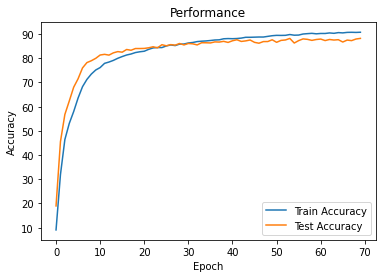

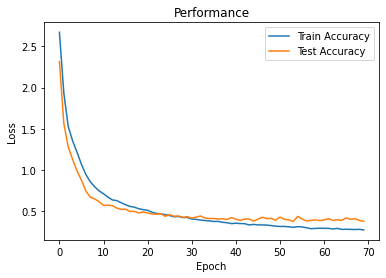

KWS_CNN(
  (conv1): Conv1d(1, 8, kernel_size=(13,), stride=(1,))
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(11,), stride=(1,))
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (dropout4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=6080, out_features=256, bias=True)
  (dropout5): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout6): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=128, out_features=31, bias=True)
)
Training


100%|██████████| 400/400 [00:07<00:00, 54.56it/s]


Epoch: [1]  loss: [2.70] Accuracy [8.30] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.15it/s]



Validation Epoch #1			Loss: 239.0633 Acc@1: 16.05%
Training


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


Epoch: [2]  loss: [2.07] Accuracy [26.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.20it/s]



Validation Epoch #2			Loss: 173.1506 Acc@1: 39.35%
Training


100%|██████████| 400/400 [00:07<00:00, 53.73it/s]


Epoch: [3]  loss: [1.68] Accuracy [40.66] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.97it/s]



Validation Epoch #3			Loss: 147.9587 Acc@1: 48.78%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [4]  loss: [1.51] Accuracy [46.71] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.02it/s]



Validation Epoch #4			Loss: 135.3475 Acc@1: 51.69%
Training


100%|██████████| 400/400 [00:07<00:00, 54.03it/s]


Epoch: [5]  loss: [1.37] Accuracy [51.77] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.05it/s]



Validation Epoch #5			Loss: 109.2758 Acc@1: 62.99%
Training


100%|██████████| 400/400 [00:07<00:00, 53.78it/s]


Epoch: [6]  loss: [1.22] Accuracy [57.88] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.37it/s]



Validation Epoch #6			Loss: 97.1370 Acc@1: 67.31%
Training


100%|██████████| 400/400 [00:07<00:00, 53.74it/s]


Epoch: [7]  loss: [1.12] Accuracy [61.95] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.61it/s]



Validation Epoch #7			Loss: 87.5442 Acc@1: 71.12%
Training


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


Epoch: [8]  loss: [1.04] Accuracy [64.86] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.82it/s]



Validation Epoch #8			Loss: 87.4133 Acc@1: 70.72%
Training


100%|██████████| 400/400 [00:07<00:00, 53.77it/s]


Epoch: [9]  loss: [0.99] Accuracy [66.84] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.82it/s]



Validation Epoch #9			Loss: 74.6833 Acc@1: 75.09%
Training


100%|██████████| 400/400 [00:07<00:00, 53.76it/s]


Epoch: [10]  loss: [0.93] Accuracy [68.92] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.29it/s]



Validation Epoch #10			Loss: 71.7521 Acc@1: 76.52%
Training


100%|██████████| 400/400 [00:07<00:00, 54.40it/s]


Epoch: [11]  loss: [0.90] Accuracy [69.81] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.62it/s]



Validation Epoch #11			Loss: 69.6796 Acc@1: 77.74%
Training


100%|██████████| 400/400 [00:07<00:00, 54.35it/s]


Epoch: [12]  loss: [0.86] Accuracy [71.49] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.58it/s]



Validation Epoch #12			Loss: 65.1066 Acc@1: 78.80%
Training


100%|██████████| 400/400 [00:07<00:00, 54.08it/s]


Epoch: [13]  loss: [0.82] Accuracy [72.33] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.28it/s]



Validation Epoch #13			Loss: 62.8955 Acc@1: 79.79%
Training


100%|██████████| 400/400 [00:07<00:00, 53.89it/s]


Epoch: [14]  loss: [0.80] Accuracy [73.19] 
validation


100%|██████████| 100/100 [00:00<00:00, 157.01it/s]



Validation Epoch #14			Loss: 61.8151 Acc@1: 79.69%
Training


100%|██████████| 400/400 [00:07<00:00, 53.49it/s]


Epoch: [15]  loss: [0.77] Accuracy [74.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.91it/s]



Validation Epoch #15			Loss: 59.7416 Acc@1: 80.25%
Training


100%|██████████| 400/400 [00:07<00:00, 53.92it/s]


Epoch: [16]  loss: [0.76] Accuracy [74.91] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.18it/s]



Validation Epoch #16			Loss: 58.4014 Acc@1: 80.67%
Training


100%|██████████| 400/400 [00:07<00:00, 53.87it/s]


Epoch: [17]  loss: [0.74] Accuracy [75.52] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.62it/s]



Validation Epoch #17			Loss: 57.0426 Acc@1: 81.76%
Training


100%|██████████| 400/400 [00:07<00:00, 53.26it/s]


Epoch: [18]  loss: [0.72] Accuracy [75.89] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.76it/s]



Validation Epoch #18			Loss: 56.1166 Acc@1: 81.76%
Training


100%|██████████| 400/400 [00:07<00:00, 54.29it/s]


Epoch: [19]  loss: [0.71] Accuracy [76.31] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.43it/s]



Validation Epoch #19			Loss: 53.7066 Acc@1: 82.14%
Training


100%|██████████| 400/400 [00:07<00:00, 54.58it/s]


Epoch: [20]  loss: [0.70] Accuracy [76.63] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.87it/s]



Validation Epoch #20			Loss: 52.9008 Acc@1: 83.14%
Training


100%|██████████| 400/400 [00:07<00:00, 53.58it/s]


Epoch: [21]  loss: [0.67] Accuracy [77.59] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.43it/s]



Validation Epoch #21			Loss: 53.1344 Acc@1: 82.92%
Training


100%|██████████| 400/400 [00:07<00:00, 53.46it/s]


Epoch: [22]  loss: [0.67] Accuracy [77.99] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.34it/s]



Validation Epoch #22			Loss: 54.0996 Acc@1: 82.23%
Training


100%|██████████| 400/400 [00:07<00:00, 53.70it/s]


Epoch: [23]  loss: [0.66] Accuracy [78.39] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.88it/s]



Validation Epoch #23			Loss: 52.1806 Acc@1: 82.78%
Training


100%|██████████| 400/400 [00:07<00:00, 53.61it/s]


Epoch: [24]  loss: [0.64] Accuracy [78.88] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.12it/s]



Validation Epoch #24			Loss: 53.6916 Acc@1: 82.40%
Training


100%|██████████| 400/400 [00:07<00:00, 53.59it/s]


Epoch: [25]  loss: [0.63] Accuracy [79.11] 
validation


100%|██████████| 100/100 [00:00<00:00, 176.67it/s]



Validation Epoch #25			Loss: 50.3988 Acc@1: 83.50%
Training


100%|██████████| 400/400 [00:07<00:00, 53.57it/s]


Epoch: [26]  loss: [0.62] Accuracy [79.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.80it/s]



Validation Epoch #26			Loss: 49.3773 Acc@1: 83.71%
Training


100%|██████████| 400/400 [00:07<00:00, 53.74it/s]


Epoch: [27]  loss: [0.62] Accuracy [79.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.71it/s]



Validation Epoch #27			Loss: 47.5859 Acc@1: 84.60%
Training


100%|██████████| 400/400 [00:07<00:00, 53.61it/s]


Epoch: [28]  loss: [0.60] Accuracy [80.39] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.81it/s]



Validation Epoch #28			Loss: 46.3652 Acc@1: 84.87%
Training


100%|██████████| 400/400 [00:07<00:00, 53.23it/s]


Epoch: [29]  loss: [0.60] Accuracy [80.31] 
validation


100%|██████████| 100/100 [00:00<00:00, 172.00it/s]



Validation Epoch #29			Loss: 51.1447 Acc@1: 82.90%
Training


100%|██████████| 400/400 [00:07<00:00, 53.24it/s]


Epoch: [30]  loss: [0.58] Accuracy [80.43] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.54it/s]



Validation Epoch #30			Loss: 46.2731 Acc@1: 84.85%
Training


100%|██████████| 400/400 [00:07<00:00, 53.22it/s]


Epoch: [31]  loss: [0.58] Accuracy [80.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 171.20it/s]



Validation Epoch #31			Loss: 44.3206 Acc@1: 85.81%
Training


100%|██████████| 400/400 [00:07<00:00, 53.16it/s]


Epoch: [32]  loss: [0.57] Accuracy [81.18] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.83it/s]



Validation Epoch #32			Loss: 46.3797 Acc@1: 85.01%
Training


100%|██████████| 400/400 [00:07<00:00, 53.08it/s]


Epoch: [33]  loss: [0.56] Accuracy [81.36] 
validation


100%|██████████| 100/100 [00:00<00:00, 177.89it/s]



Validation Epoch #33			Loss: 46.7298 Acc@1: 84.68%
Training


100%|██████████| 400/400 [00:07<00:00, 52.98it/s]


Epoch: [34]  loss: [0.57] Accuracy [81.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.44it/s]



Validation Epoch #34			Loss: 44.9638 Acc@1: 85.12%
Training


100%|██████████| 400/400 [00:07<00:00, 53.34it/s]


Epoch: [35]  loss: [0.56] Accuracy [81.52] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.10it/s]



Validation Epoch #35			Loss: 46.2962 Acc@1: 84.70%
Training


100%|██████████| 400/400 [00:07<00:00, 53.50it/s]


Epoch: [36]  loss: [0.55] Accuracy [81.61] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.48it/s]



Validation Epoch #36			Loss: 45.8357 Acc@1: 85.18%
Training


100%|██████████| 400/400 [00:07<00:00, 53.37it/s]


Epoch: [37]  loss: [0.54] Accuracy [82.06] 
validation


100%|██████████| 100/100 [00:00<00:00, 177.15it/s]



Validation Epoch #37			Loss: 44.3645 Acc@1: 85.79%
Training


100%|██████████| 400/400 [00:07<00:00, 53.34it/s]


Epoch: [38]  loss: [0.53] Accuracy [82.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.28it/s]



Validation Epoch #38			Loss: 44.8546 Acc@1: 85.13%
Training


100%|██████████| 400/400 [00:07<00:00, 53.46it/s]


Epoch: [39]  loss: [0.53] Accuracy [82.79] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.25it/s]



Validation Epoch #39			Loss: 44.7322 Acc@1: 84.98%
Training


100%|██████████| 400/400 [00:07<00:00, 53.50it/s]


Epoch: [40]  loss: [0.52] Accuracy [83.14] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.42it/s]



Validation Epoch #40			Loss: 43.8948 Acc@1: 85.14%
Training


100%|██████████| 400/400 [00:07<00:00, 53.65it/s]


Epoch: [41]  loss: [0.52] Accuracy [82.73] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.66it/s]



Validation Epoch #41			Loss: 43.7146 Acc@1: 85.46%
Training


100%|██████████| 400/400 [00:07<00:00, 53.40it/s]


Epoch: [42]  loss: [0.52] Accuracy [83.02] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.47it/s]



Validation Epoch #42			Loss: 43.8646 Acc@1: 85.53%
Training


100%|██████████| 400/400 [00:07<00:00, 53.56it/s]


Epoch: [43]  loss: [0.51] Accuracy [83.20] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.49it/s]



Validation Epoch #43			Loss: 43.0936 Acc@1: 85.77%
Training


100%|██████████| 400/400 [00:07<00:00, 53.62it/s]


Epoch: [44]  loss: [0.50] Accuracy [83.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 172.23it/s]



Validation Epoch #44			Loss: 44.8445 Acc@1: 85.01%
Training


100%|██████████| 400/400 [00:07<00:00, 53.48it/s]


Epoch: [45]  loss: [0.52] Accuracy [83.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.22it/s]



Validation Epoch #45			Loss: 42.7711 Acc@1: 85.85%
Training


100%|██████████| 400/400 [00:07<00:00, 53.66it/s]


Epoch: [46]  loss: [0.50] Accuracy [83.53] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.48it/s]



Validation Epoch #46			Loss: 43.8393 Acc@1: 85.47%
Training


100%|██████████| 400/400 [00:07<00:00, 53.83it/s]


Epoch: [47]  loss: [0.50] Accuracy [83.43] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.14it/s]



Validation Epoch #47			Loss: 41.4046 Acc@1: 86.53%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [48]  loss: [0.50] Accuracy [83.52] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.62it/s]



Validation Epoch #48			Loss: 41.6843 Acc@1: 86.21%
Training


100%|██████████| 400/400 [00:07<00:00, 54.17it/s]


Epoch: [49]  loss: [0.49] Accuracy [83.89] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.02it/s]



Validation Epoch #49			Loss: 44.0355 Acc@1: 85.73%
Training


100%|██████████| 400/400 [00:07<00:00, 54.16it/s]


Epoch: [50]  loss: [0.49] Accuracy [84.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.31it/s]



Validation Epoch #50			Loss: 41.2678 Acc@1: 86.43%
Training


100%|██████████| 400/400 [00:07<00:00, 54.43it/s]


Epoch: [51]  loss: [0.49] Accuracy [83.91] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.60it/s]



Validation Epoch #51			Loss: 43.6704 Acc@1: 85.73%
Training


100%|██████████| 400/400 [00:07<00:00, 54.20it/s]


Epoch: [52]  loss: [0.47] Accuracy [84.27] 
validation


100%|██████████| 100/100 [00:00<00:00, 159.54it/s]



Validation Epoch #52			Loss: 42.6570 Acc@1: 86.11%
Training


100%|██████████| 400/400 [00:07<00:00, 53.25it/s]


Epoch: [53]  loss: [0.47] Accuracy [84.17] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.43it/s]



Validation Epoch #53			Loss: 40.2648 Acc@1: 86.97%
Training


100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Epoch: [54]  loss: [0.48] Accuracy [84.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.31it/s]



Validation Epoch #54			Loss: 41.9268 Acc@1: 86.09%
Training


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


Epoch: [55]  loss: [0.46] Accuracy [84.70] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.70it/s]



Validation Epoch #55			Loss: 43.4216 Acc@1: 85.44%
Training


100%|██████████| 400/400 [00:07<00:00, 53.82it/s]


Epoch: [56]  loss: [0.47] Accuracy [84.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.28it/s]



Validation Epoch #56			Loss: 39.4818 Acc@1: 86.85%
Training


100%|██████████| 400/400 [00:07<00:00, 54.35it/s]


Epoch: [57]  loss: [0.47] Accuracy [84.39] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.81it/s]



Validation Epoch #57			Loss: 42.5834 Acc@1: 85.84%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [58]  loss: [0.46] Accuracy [84.81] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.48it/s]



Validation Epoch #58			Loss: 39.6359 Acc@1: 86.92%
Training


100%|██████████| 400/400 [00:07<00:00, 54.16it/s]


Epoch: [59]  loss: [0.46] Accuracy [84.61] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.95it/s]



Validation Epoch #59			Loss: 41.6900 Acc@1: 86.57%
Training


100%|██████████| 400/400 [00:07<00:00, 54.16it/s]


Epoch: [60]  loss: [0.46] Accuracy [84.95] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.58it/s]



Validation Epoch #60			Loss: 41.8369 Acc@1: 86.37%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [61]  loss: [0.46] Accuracy [84.94] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.10it/s]



Validation Epoch #61			Loss: 41.0961 Acc@1: 86.39%
Training


100%|██████████| 400/400 [00:07<00:00, 53.86it/s]


Epoch: [62]  loss: [0.45] Accuracy [85.22] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.60it/s]



Validation Epoch #62			Loss: 40.3732 Acc@1: 86.25%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [63]  loss: [0.45] Accuracy [84.99] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.40it/s]



Validation Epoch #63			Loss: 40.9713 Acc@1: 86.32%
Training


100%|██████████| 400/400 [00:07<00:00, 54.00it/s]


Epoch: [64]  loss: [0.45] Accuracy [85.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.27it/s]



Validation Epoch #64			Loss: 40.7649 Acc@1: 86.25%
Training


100%|██████████| 400/400 [00:07<00:00, 54.20it/s]


Epoch: [65]  loss: [0.44] Accuracy [85.05] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.95it/s]



Validation Epoch #65			Loss: 38.8861 Acc@1: 87.45%
Training


100%|██████████| 400/400 [00:07<00:00, 54.12it/s]


Epoch: [66]  loss: [0.44] Accuracy [85.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.01it/s]



Validation Epoch #66			Loss: 38.4491 Acc@1: 87.05%
Training


100%|██████████| 400/400 [00:07<00:00, 54.28it/s]


Epoch: [67]  loss: [0.45] Accuracy [85.18] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.52it/s]



Validation Epoch #67			Loss: 39.8525 Acc@1: 87.06%
Training


100%|██████████| 400/400 [00:07<00:00, 54.32it/s]


Epoch: [68]  loss: [0.44] Accuracy [85.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.92it/s]



Validation Epoch #68			Loss: 42.4347 Acc@1: 86.06%
Training


100%|██████████| 400/400 [00:07<00:00, 54.19it/s]


Epoch: [69]  loss: [0.43] Accuracy [85.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.58it/s]



Validation Epoch #69			Loss: 38.0990 Acc@1: 87.24%
Training


100%|██████████| 400/400 [00:07<00:00, 54.19it/s]


Epoch: [70]  loss: [0.43] Accuracy [85.63] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.43it/s]



Validation Epoch #70			Loss: 39.7251 Acc@1: 87.08%


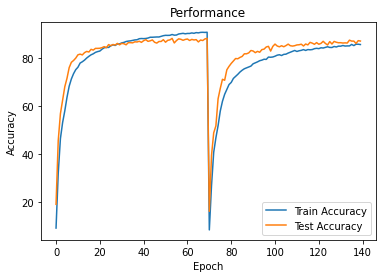

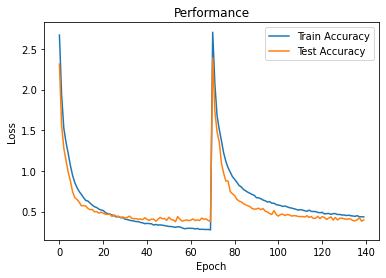

KWS_CNN(
  (conv1): Conv1d(1, 8, kernel_size=(13,), stride=(1,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(11,), stride=(1,))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6080, out_features=256, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=31, bias=True)
)
Training


100%|██████████| 400/400 [00:07<00:00, 52.53it/s]


Epoch: [1]  loss: [2.75] Accuracy [7.07] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.26it/s]



Validation Epoch #1			Loss: 269.7263 Acc@1: 6.96%
Training


100%|██████████| 400/400 [00:07<00:00, 54.08it/s]


Epoch: [2]  loss: [2.56] Accuracy [11.39] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.53it/s]



Validation Epoch #2			Loss: 235.7884 Acc@1: 20.54%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [3]  loss: [2.02] Accuracy [29.15] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.75it/s]



Validation Epoch #3			Loss: 194.7353 Acc@1: 36.58%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [4]  loss: [1.75] Accuracy [39.10] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.37it/s]



Validation Epoch #4			Loss: 163.5526 Acc@1: 44.00%
Training


100%|██████████| 400/400 [00:07<00:00, 54.25it/s]


Epoch: [5]  loss: [1.59] Accuracy [44.41] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.27it/s]



Validation Epoch #5			Loss: 136.2441 Acc@1: 54.46%
Training


100%|██████████| 400/400 [00:07<00:00, 54.31it/s]


Epoch: [6]  loss: [1.42] Accuracy [51.37] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.03it/s]



Validation Epoch #6			Loss: 121.7464 Acc@1: 60.48%
Training


100%|██████████| 400/400 [00:07<00:00, 54.26it/s]


Epoch: [7]  loss: [1.29] Accuracy [56.35] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.72it/s]



Validation Epoch #7			Loss: 105.5641 Acc@1: 66.80%
Training


100%|██████████| 400/400 [00:07<00:00, 54.26it/s]


Epoch: [8]  loss: [1.21] Accuracy [59.37] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.63it/s]



Validation Epoch #8			Loss: 98.6767 Acc@1: 68.10%
Training


100%|██████████| 400/400 [00:07<00:00, 54.20it/s]


Epoch: [9]  loss: [1.15] Accuracy [61.56] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.01it/s]



Validation Epoch #9			Loss: 99.8868 Acc@1: 67.14%
Training


100%|██████████| 400/400 [00:07<00:00, 54.13it/s]


Epoch: [10]  loss: [1.11] Accuracy [62.97] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.56it/s]



Validation Epoch #10			Loss: 89.4618 Acc@1: 71.52%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [11]  loss: [1.07] Accuracy [64.48] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.26it/s]



Validation Epoch #11			Loss: 88.8539 Acc@1: 71.28%
Training


100%|██████████| 400/400 [00:07<00:00, 53.99it/s]


Epoch: [12]  loss: [1.04] Accuracy [65.14] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.29it/s]



Validation Epoch #12			Loss: 85.0133 Acc@1: 72.44%
Training


100%|██████████| 400/400 [00:07<00:00, 54.08it/s]


Epoch: [13]  loss: [1.01] Accuracy [66.49] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.45it/s]



Validation Epoch #13			Loss: 75.6076 Acc@1: 76.13%
Training


100%|██████████| 400/400 [00:07<00:00, 54.04it/s]


Epoch: [14]  loss: [0.99] Accuracy [67.17] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.17it/s]



Validation Epoch #14			Loss: 78.5982 Acc@1: 75.34%
Training


100%|██████████| 400/400 [00:07<00:00, 53.72it/s]


Epoch: [15]  loss: [0.97] Accuracy [67.83] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.46it/s]



Validation Epoch #15			Loss: 72.5745 Acc@1: 77.15%
Training


100%|██████████| 400/400 [00:07<00:00, 54.29it/s]


Epoch: [16]  loss: [0.96] Accuracy [68.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.62it/s]



Validation Epoch #16			Loss: 75.4887 Acc@1: 75.77%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [17]  loss: [0.93] Accuracy [69.23] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.20it/s]



Validation Epoch #17			Loss: 69.8642 Acc@1: 77.62%
Training


100%|██████████| 400/400 [00:07<00:00, 54.20it/s]


Epoch: [18]  loss: [0.91] Accuracy [69.94] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.88it/s]



Validation Epoch #18			Loss: 75.3143 Acc@1: 74.95%
Training


100%|██████████| 400/400 [00:07<00:00, 54.10it/s]


Epoch: [19]  loss: [0.91] Accuracy [70.33] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.23it/s]



Validation Epoch #19			Loss: 73.5231 Acc@1: 76.04%
Training


100%|██████████| 400/400 [00:07<00:00, 53.45it/s]


Epoch: [20]  loss: [0.89] Accuracy [70.90] 
validation


100%|██████████| 100/100 [00:00<00:00, 164.66it/s]



Validation Epoch #20			Loss: 67.7945 Acc@1: 78.39%
Training


100%|██████████| 400/400 [00:07<00:00, 53.69it/s]


Epoch: [21]  loss: [0.87] Accuracy [71.48] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.67it/s]



Validation Epoch #21			Loss: 66.8790 Acc@1: 78.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Epoch: [22]  loss: [0.87] Accuracy [71.46] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.74it/s]



Validation Epoch #22			Loss: 66.7929 Acc@1: 77.85%
Training


100%|██████████| 400/400 [00:07<00:00, 54.22it/s]


Epoch: [23]  loss: [0.86] Accuracy [71.97] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.55it/s]



Validation Epoch #23			Loss: 67.0704 Acc@1: 78.52%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [24]  loss: [0.85] Accuracy [72.23] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.20it/s]



Validation Epoch #24			Loss: 65.6528 Acc@1: 78.98%
Training


100%|██████████| 400/400 [00:07<00:00, 54.27it/s]


Epoch: [25]  loss: [0.83] Accuracy [72.58] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.74it/s]



Validation Epoch #25			Loss: 62.8666 Acc@1: 79.72%
Training


100%|██████████| 400/400 [00:07<00:00, 54.50it/s]


Epoch: [26]  loss: [0.83] Accuracy [72.70] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.67it/s]



Validation Epoch #26			Loss: 62.9074 Acc@1: 79.59%
Training


100%|██████████| 400/400 [00:07<00:00, 54.16it/s]


Epoch: [27]  loss: [0.82] Accuracy [73.06] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.38it/s]



Validation Epoch #27			Loss: 62.3780 Acc@1: 79.65%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [28]  loss: [0.81] Accuracy [73.60] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.15it/s]



Validation Epoch #28			Loss: 62.3931 Acc@1: 79.57%
Training


100%|██████████| 400/400 [00:07<00:00, 54.17it/s]


Epoch: [29]  loss: [0.80] Accuracy [73.83] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.74it/s]



Validation Epoch #29			Loss: 58.5291 Acc@1: 81.33%
Training


100%|██████████| 400/400 [00:07<00:00, 54.26it/s]


Epoch: [30]  loss: [0.81] Accuracy [73.78] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.58it/s]



Validation Epoch #30			Loss: 58.9897 Acc@1: 81.51%
Training


100%|██████████| 400/400 [00:07<00:00, 54.37it/s]


Epoch: [31]  loss: [0.79] Accuracy [74.31] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.21it/s]



Validation Epoch #31			Loss: 58.9451 Acc@1: 80.98%
Training


100%|██████████| 400/400 [00:07<00:00, 54.30it/s]


Epoch: [32]  loss: [0.78] Accuracy [74.39] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.65it/s]



Validation Epoch #32			Loss: 58.8654 Acc@1: 81.22%
Training


100%|██████████| 400/400 [00:07<00:00, 54.33it/s]


Epoch: [33]  loss: [0.77] Accuracy [74.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.16it/s]



Validation Epoch #33			Loss: 61.5341 Acc@1: 79.49%
Training


100%|██████████| 400/400 [00:07<00:00, 54.36it/s]


Epoch: [34]  loss: [0.77] Accuracy [74.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.51it/s]



Validation Epoch #34			Loss: 58.4335 Acc@1: 80.96%
Training


100%|██████████| 400/400 [00:07<00:00, 53.92it/s]


Epoch: [35]  loss: [0.76] Accuracy [75.29] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.33it/s]



Validation Epoch #35			Loss: 56.2117 Acc@1: 81.81%
Training


100%|██████████| 400/400 [00:07<00:00, 54.28it/s]


Epoch: [36]  loss: [0.76] Accuracy [75.11] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.25it/s]



Validation Epoch #36			Loss: 58.7225 Acc@1: 80.68%
Training


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


Epoch: [37]  loss: [0.76] Accuracy [75.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.05it/s]



Validation Epoch #37			Loss: 57.5064 Acc@1: 80.99%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [38]  loss: [0.74] Accuracy [75.81] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.56it/s]



Validation Epoch #38			Loss: 56.5759 Acc@1: 81.80%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [39]  loss: [0.75] Accuracy [75.36] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.14it/s]



Validation Epoch #39			Loss: 57.7751 Acc@1: 81.11%
Training


100%|██████████| 400/400 [00:07<00:00, 54.17it/s]


Epoch: [40]  loss: [0.74] Accuracy [75.83] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.45it/s]



Validation Epoch #40			Loss: 56.1142 Acc@1: 81.42%
Training


100%|██████████| 400/400 [00:07<00:00, 54.12it/s]


Epoch: [41]  loss: [0.73] Accuracy [76.22] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.73it/s]



Validation Epoch #41			Loss: 62.4259 Acc@1: 79.25%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [42]  loss: [0.73] Accuracy [76.22] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.73it/s]



Validation Epoch #42			Loss: 58.4380 Acc@1: 81.12%
Training


100%|██████████| 400/400 [00:07<00:00, 54.07it/s]


Epoch: [43]  loss: [0.72] Accuracy [76.70] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.35it/s]



Validation Epoch #43			Loss: 59.8978 Acc@1: 80.05%
Training


100%|██████████| 400/400 [00:07<00:00, 54.36it/s]


Epoch: [44]  loss: [0.72] Accuracy [76.45] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.02it/s]



Validation Epoch #44			Loss: 54.8684 Acc@1: 82.01%
Training


100%|██████████| 400/400 [00:07<00:00, 54.50it/s]


Epoch: [45]  loss: [0.72] Accuracy [76.47] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.28it/s]



Validation Epoch #45			Loss: 55.3694 Acc@1: 82.12%
Training


100%|██████████| 400/400 [00:07<00:00, 54.30it/s]


Epoch: [46]  loss: [0.71] Accuracy [77.13] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.95it/s]



Validation Epoch #46			Loss: 55.2683 Acc@1: 82.00%
Training


100%|██████████| 400/400 [00:07<00:00, 54.20it/s]


Epoch: [47]  loss: [0.71] Accuracy [77.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.22it/s]



Validation Epoch #47			Loss: 54.3379 Acc@1: 82.30%
Training


100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Epoch: [48]  loss: [0.71] Accuracy [76.87] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.32it/s]



Validation Epoch #48			Loss: 55.7731 Acc@1: 81.53%
Training


100%|██████████| 400/400 [00:07<00:00, 54.13it/s]


Epoch: [49]  loss: [0.71] Accuracy [76.81] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.64it/s]



Validation Epoch #49			Loss: 55.9293 Acc@1: 81.78%
Training


100%|██████████| 400/400 [00:07<00:00, 54.19it/s]


Epoch: [50]  loss: [0.71] Accuracy [77.17] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.59it/s]



Validation Epoch #50			Loss: 54.0865 Acc@1: 82.45%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [51]  loss: [0.70] Accuracy [77.59] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.32it/s]



Validation Epoch #51			Loss: 55.0602 Acc@1: 82.14%
Training


100%|██████████| 400/400 [00:07<00:00, 54.23it/s]


Epoch: [52]  loss: [0.69] Accuracy [77.57] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.65it/s]



Validation Epoch #52			Loss: 55.8886 Acc@1: 81.44%
Training


100%|██████████| 400/400 [00:08<00:00, 49.72it/s]


Epoch: [53]  loss: [0.69] Accuracy [77.54] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.16it/s]



Validation Epoch #53			Loss: 52.9661 Acc@1: 83.31%
Training


100%|██████████| 400/400 [00:08<00:00, 45.61it/s]


Epoch: [54]  loss: [0.69] Accuracy [77.71] 
validation


100%|██████████| 100/100 [00:00<00:00, 147.48it/s]



Validation Epoch #54			Loss: 52.0150 Acc@1: 83.22%
Training


100%|██████████| 400/400 [00:09<00:00, 43.90it/s]


Epoch: [55]  loss: [0.69] Accuracy [77.61] 
validation


100%|██████████| 100/100 [00:00<00:00, 124.01it/s]



Validation Epoch #55			Loss: 51.3042 Acc@1: 83.53%
Training


100%|██████████| 400/400 [00:07<00:00, 51.19it/s]


Epoch: [56]  loss: [0.68] Accuracy [77.82] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.94it/s]



Validation Epoch #56			Loss: 52.8558 Acc@1: 82.91%
Training


100%|██████████| 400/400 [00:07<00:00, 53.06it/s]


Epoch: [57]  loss: [0.69] Accuracy [77.68] 
validation


100%|██████████| 100/100 [00:00<00:00, 160.29it/s]



Validation Epoch #57			Loss: 59.0934 Acc@1: 80.14%
Training


100%|██████████| 400/400 [00:08<00:00, 46.31it/s]


Epoch: [58]  loss: [0.68] Accuracy [77.99] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.34it/s]



Validation Epoch #58			Loss: 52.5058 Acc@1: 83.26%
Training


100%|██████████| 400/400 [00:07<00:00, 51.21it/s]


Epoch: [59]  loss: [0.67] Accuracy [78.22] 
validation


100%|██████████| 100/100 [00:00<00:00, 187.12it/s]



Validation Epoch #59			Loss: 51.3975 Acc@1: 83.05%
Training


100%|██████████| 400/400 [00:08<00:00, 49.17it/s]


Epoch: [60]  loss: [0.68] Accuracy [77.74] 
validation


100%|██████████| 100/100 [00:00<00:00, 163.97it/s]



Validation Epoch #60			Loss: 56.5413 Acc@1: 81.30%
Training


100%|██████████| 400/400 [00:07<00:00, 52.08it/s]


Epoch: [61]  loss: [0.67] Accuracy [78.08] 
validation


100%|██████████| 100/100 [00:00<00:00, 173.85it/s]



Validation Epoch #61			Loss: 52.5350 Acc@1: 82.67%
Training


100%|██████████| 400/400 [00:07<00:00, 54.03it/s]


Epoch: [62]  loss: [0.68] Accuracy [78.08] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.04it/s]



Validation Epoch #62			Loss: 52.5803 Acc@1: 82.43%
Training


100%|██████████| 400/400 [00:07<00:00, 54.03it/s]


Epoch: [63]  loss: [0.67] Accuracy [78.12] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.66it/s]



Validation Epoch #63			Loss: 50.2716 Acc@1: 83.78%
Training


100%|██████████| 400/400 [00:07<00:00, 54.13it/s]


Epoch: [64]  loss: [0.66] Accuracy [78.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.58it/s]



Validation Epoch #64			Loss: 49.5260 Acc@1: 84.04%
Training


100%|██████████| 400/400 [00:07<00:00, 54.21it/s]


Epoch: [65]  loss: [0.66] Accuracy [78.52] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.38it/s]



Validation Epoch #65			Loss: 51.3268 Acc@1: 83.41%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [66]  loss: [0.66] Accuracy [78.46] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.45it/s]



Validation Epoch #66			Loss: 54.8776 Acc@1: 81.71%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [67]  loss: [0.66] Accuracy [78.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.01it/s]



Validation Epoch #67			Loss: 49.7497 Acc@1: 84.04%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [68]  loss: [0.66] Accuracy [79.01] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.87it/s]



Validation Epoch #68			Loss: 55.3337 Acc@1: 81.31%
Training


100%|██████████| 400/400 [00:07<00:00, 54.00it/s]


Epoch: [69]  loss: [0.66] Accuracy [78.82] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.33it/s]



Validation Epoch #69			Loss: 53.9572 Acc@1: 82.00%
Training


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


Epoch: [70]  loss: [0.65] Accuracy [79.01] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.91it/s]



Validation Epoch #70			Loss: 50.6435 Acc@1: 83.54%


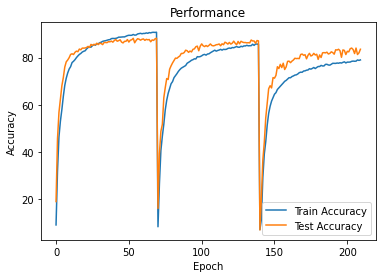

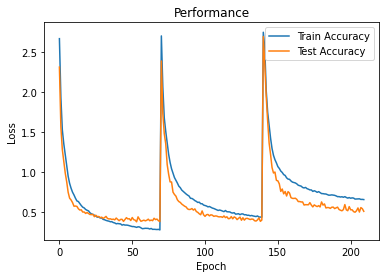

KWS_CNN(
  (conv1): Conv1d(1, 8, kernel_size=(13,), stride=(1,))
  (dropout1): Dropout(p=0.6, inplace=False)
  (conv2): Conv1d(8, 16, kernel_size=(11,), stride=(1,))
  (dropout2): Dropout(p=0.6, inplace=False)
  (conv3): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
  (dropout3): Dropout(p=0.6, inplace=False)
  (conv4): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (dropout4): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=6080, out_features=256, bias=True)
  (dropout5): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=128, out_features=31, bias=True)
)
Training


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


Epoch: [1]  loss: [2.77] Accuracy [7.10] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.48it/s]



Validation Epoch #1			Loss: 270.1770 Acc@1: 7.13%
Training


100%|██████████| 400/400 [00:07<00:00, 53.92it/s]


Epoch: [2]  loss: [2.69] Accuracy [6.85] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.53it/s]



Validation Epoch #2			Loss: 268.7369 Acc@1: 6.94%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [3]  loss: [2.59] Accuracy [10.60] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.63it/s]



Validation Epoch #3			Loss: 349.1069 Acc@1: 6.92%
Training


100%|██████████| 400/400 [00:07<00:00, 52.65it/s]


Epoch: [4]  loss: [2.25] Accuracy [20.96] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.20it/s]



Validation Epoch #4			Loss: 363.4804 Acc@1: 9.44%
Training


100%|██████████| 400/400 [00:07<00:00, 50.80it/s]


Epoch: [5]  loss: [1.99] Accuracy [30.83] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.46it/s]



Validation Epoch #5			Loss: 311.7666 Acc@1: 9.16%
Training


100%|██████████| 400/400 [00:07<00:00, 53.95it/s]


Epoch: [6]  loss: [1.82] Accuracy [36.57] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.03it/s]



Validation Epoch #6			Loss: 269.5462 Acc@1: 16.61%
Training


100%|██████████| 400/400 [00:07<00:00, 53.70it/s]


Epoch: [7]  loss: [1.72] Accuracy [40.43] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.11it/s]



Validation Epoch #7			Loss: 251.7096 Acc@1: 18.13%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [8]  loss: [1.62] Accuracy [43.45] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.09it/s]



Validation Epoch #8			Loss: 178.1360 Acc@1: 37.76%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [9]  loss: [1.51] Accuracy [48.09] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.92it/s]



Validation Epoch #9			Loss: 156.6321 Acc@1: 47.20%
Training


100%|██████████| 400/400 [00:07<00:00, 54.09it/s]


Epoch: [10]  loss: [1.44] Accuracy [50.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.93it/s]



Validation Epoch #10			Loss: 143.8849 Acc@1: 50.77%
Training


100%|██████████| 400/400 [00:07<00:00, 54.07it/s]


Epoch: [11]  loss: [1.39] Accuracy [52.62] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.71it/s]



Validation Epoch #11			Loss: 160.3106 Acc@1: 44.14%
Training


100%|██████████| 400/400 [00:07<00:00, 54.18it/s]


Epoch: [12]  loss: [1.34] Accuracy [54.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.26it/s]



Validation Epoch #12			Loss: 129.4435 Acc@1: 58.18%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [13]  loss: [1.32] Accuracy [55.46] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.28it/s]



Validation Epoch #13			Loss: 135.5828 Acc@1: 55.69%
Training


100%|██████████| 400/400 [00:07<00:00, 54.00it/s]


Epoch: [14]  loss: [1.27] Accuracy [56.88] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.59it/s]



Validation Epoch #14			Loss: 130.4980 Acc@1: 57.44%
Training


100%|██████████| 400/400 [00:07<00:00, 53.96it/s]


Epoch: [15]  loss: [1.26] Accuracy [57.65] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.95it/s]



Validation Epoch #15			Loss: 136.6988 Acc@1: 52.83%
Training


100%|██████████| 400/400 [00:07<00:00, 53.96it/s]


Epoch: [16]  loss: [1.24] Accuracy [58.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.61it/s]



Validation Epoch #16			Loss: 133.0296 Acc@1: 56.52%
Training


100%|██████████| 400/400 [00:07<00:00, 53.90it/s]


Epoch: [17]  loss: [1.21] Accuracy [59.58] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.87it/s]



Validation Epoch #17			Loss: 123.3993 Acc@1: 60.10%
Training


100%|██████████| 400/400 [00:07<00:00, 53.88it/s]


Epoch: [18]  loss: [1.19] Accuracy [60.50] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.26it/s]



Validation Epoch #18			Loss: 112.2214 Acc@1: 63.98%
Training


100%|██████████| 400/400 [00:07<00:00, 53.92it/s]


Epoch: [19]  loss: [1.19] Accuracy [60.56] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.02it/s]



Validation Epoch #19			Loss: 108.7701 Acc@1: 66.04%
Training


100%|██████████| 400/400 [00:07<00:00, 54.29it/s]


Epoch: [20]  loss: [1.17] Accuracy [61.30] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.38it/s]



Validation Epoch #20			Loss: 115.5587 Acc@1: 63.42%
Training


100%|██████████| 400/400 [00:07<00:00, 54.12it/s]


Epoch: [21]  loss: [1.15] Accuracy [61.79] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.81it/s]



Validation Epoch #21			Loss: 110.8311 Acc@1: 65.43%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [22]  loss: [1.13] Accuracy [62.49] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.01it/s]



Validation Epoch #22			Loss: 111.0182 Acc@1: 64.65%
Training


100%|██████████| 400/400 [00:07<00:00, 54.19it/s]


Epoch: [23]  loss: [1.12] Accuracy [63.07] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.56it/s]



Validation Epoch #23			Loss: 100.3504 Acc@1: 68.86%
Training


100%|██████████| 400/400 [00:07<00:00, 54.03it/s]


Epoch: [24]  loss: [1.11] Accuracy [63.09] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.33it/s]



Validation Epoch #24			Loss: 108.1103 Acc@1: 64.38%
Training


100%|██████████| 400/400 [00:07<00:00, 53.06it/s]


Epoch: [25]  loss: [1.10] Accuracy [63.65] 
validation


100%|██████████| 100/100 [00:00<00:00, 156.46it/s]



Validation Epoch #25			Loss: 98.2708 Acc@1: 69.20%
Training


100%|██████████| 400/400 [00:07<00:00, 53.10it/s]


Epoch: [26]  loss: [1.09] Accuracy [64.03] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.32it/s]



Validation Epoch #26			Loss: 105.2970 Acc@1: 66.13%
Training


100%|██████████| 400/400 [00:07<00:00, 54.08it/s]


Epoch: [27]  loss: [1.09] Accuracy [64.21] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.73it/s]



Validation Epoch #27			Loss: 105.5175 Acc@1: 66.35%
Training


100%|██████████| 400/400 [00:07<00:00, 53.83it/s]


Epoch: [28]  loss: [1.07] Accuracy [64.76] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.11it/s]



Validation Epoch #28			Loss: 102.7689 Acc@1: 67.29%
Training


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


Epoch: [29]  loss: [1.07] Accuracy [64.78] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.59it/s]



Validation Epoch #29			Loss: 102.4089 Acc@1: 67.27%
Training


100%|██████████| 400/400 [00:07<00:00, 53.99it/s]


Epoch: [30]  loss: [1.06] Accuracy [64.95] 
validation


100%|██████████| 100/100 [00:00<00:00, 188.14it/s]



Validation Epoch #30			Loss: 95.6396 Acc@1: 69.69%
Training


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


Epoch: [31]  loss: [1.04] Accuracy [65.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.34it/s]



Validation Epoch #31			Loss: 95.1354 Acc@1: 69.76%
Training


100%|██████████| 400/400 [00:07<00:00, 54.06it/s]


Epoch: [32]  loss: [1.04] Accuracy [65.63] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.29it/s]



Validation Epoch #32			Loss: 95.2552 Acc@1: 70.03%
Training


100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Epoch: [33]  loss: [1.03] Accuracy [66.07] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.51it/s]



Validation Epoch #33			Loss: 98.1046 Acc@1: 68.54%
Training


100%|██████████| 400/400 [00:07<00:00, 53.87it/s]


Epoch: [34]  loss: [1.02] Accuracy [66.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.11it/s]



Validation Epoch #34			Loss: 82.0387 Acc@1: 74.14%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [35]  loss: [1.02] Accuracy [66.48] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.19it/s]



Validation Epoch #35			Loss: 96.0268 Acc@1: 69.44%
Training


100%|██████████| 400/400 [00:07<00:00, 52.93it/s]


Epoch: [36]  loss: [1.01] Accuracy [66.76] 
validation


100%|██████████| 100/100 [00:00<00:00, 101.67it/s]



Validation Epoch #36			Loss: 99.3649 Acc@1: 67.02%
Training


100%|██████████| 400/400 [00:07<00:00, 54.09it/s]


Epoch: [37]  loss: [1.01] Accuracy [66.83] 
validation


100%|██████████| 100/100 [00:00<00:00, 177.12it/s]



Validation Epoch #37			Loss: 88.9568 Acc@1: 71.94%
Training


100%|██████████| 400/400 [00:07<00:00, 54.04it/s]


Epoch: [38]  loss: [1.01] Accuracy [66.78] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.43it/s]



Validation Epoch #38			Loss: 87.0242 Acc@1: 72.65%
Training


100%|██████████| 400/400 [00:07<00:00, 54.17it/s]


Epoch: [39]  loss: [1.00] Accuracy [67.37] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.39it/s]



Validation Epoch #39			Loss: 99.4320 Acc@1: 67.50%
Training


100%|██████████| 400/400 [00:07<00:00, 53.94it/s]


Epoch: [40]  loss: [0.99] Accuracy [67.73] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.01it/s]



Validation Epoch #40			Loss: 92.9935 Acc@1: 70.07%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [41]  loss: [0.99] Accuracy [67.63] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.95it/s]



Validation Epoch #41			Loss: 90.2947 Acc@1: 70.66%
Training


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


Epoch: [42]  loss: [0.99] Accuracy [67.62] 
validation


100%|██████████| 100/100 [00:00<00:00, 179.75it/s]



Validation Epoch #42			Loss: 84.3222 Acc@1: 72.33%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [43]  loss: [0.99] Accuracy [68.00] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.61it/s]



Validation Epoch #43			Loss: 92.0689 Acc@1: 69.97%
Training


100%|██████████| 400/400 [00:07<00:00, 54.09it/s]


Epoch: [44]  loss: [0.97] Accuracy [68.27] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.61it/s]



Validation Epoch #44			Loss: 83.5543 Acc@1: 73.90%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [45]  loss: [0.98] Accuracy [68.32] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.24it/s]



Validation Epoch #45			Loss: 84.2387 Acc@1: 73.96%
Training


100%|██████████| 400/400 [00:07<00:00, 54.10it/s]


Epoch: [46]  loss: [0.97] Accuracy [68.27] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.99it/s]



Validation Epoch #46			Loss: 79.5224 Acc@1: 74.90%
Training


100%|██████████| 400/400 [00:07<00:00, 54.12it/s]


Epoch: [47]  loss: [0.98] Accuracy [68.21] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.70it/s]



Validation Epoch #47			Loss: 89.7615 Acc@1: 71.29%
Training


100%|██████████| 400/400 [00:07<00:00, 54.28it/s]


Epoch: [48]  loss: [0.96] Accuracy [68.90] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.62it/s]



Validation Epoch #48			Loss: 83.5717 Acc@1: 73.50%
Training


100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Epoch: [49]  loss: [0.96] Accuracy [68.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.57it/s]



Validation Epoch #49			Loss: 81.6206 Acc@1: 73.66%
Training


100%|██████████| 400/400 [00:07<00:00, 53.80it/s]


Epoch: [50]  loss: [0.97] Accuracy [68.61] 
validation


100%|██████████| 100/100 [00:00<00:00, 177.24it/s]



Validation Epoch #50			Loss: 79.5946 Acc@1: 75.56%
Training


100%|██████████| 400/400 [00:07<00:00, 53.56it/s]


Epoch: [51]  loss: [0.95] Accuracy [68.75] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.37it/s]



Validation Epoch #51			Loss: 77.5426 Acc@1: 75.47%
Training


100%|██████████| 400/400 [00:07<00:00, 54.14it/s]


Epoch: [52]  loss: [0.95] Accuracy [69.36] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.52it/s]



Validation Epoch #52			Loss: 78.8942 Acc@1: 74.65%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [53]  loss: [0.95] Accuracy [68.93] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.72it/s]



Validation Epoch #53			Loss: 83.4330 Acc@1: 74.33%
Training


100%|██████████| 400/400 [00:07<00:00, 53.88it/s]


Epoch: [54]  loss: [0.95] Accuracy [69.42] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.65it/s]



Validation Epoch #54			Loss: 81.1167 Acc@1: 74.12%
Training


100%|██████████| 400/400 [00:07<00:00, 54.07it/s]


Epoch: [55]  loss: [0.93] Accuracy [69.62] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.93it/s]



Validation Epoch #55			Loss: 79.8049 Acc@1: 74.51%
Training


100%|██████████| 400/400 [00:07<00:00, 52.52it/s]


Epoch: [56]  loss: [0.94] Accuracy [69.67] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.04it/s]



Validation Epoch #56			Loss: 86.6827 Acc@1: 72.20%
Training


100%|██████████| 400/400 [00:07<00:00, 54.18it/s]


Epoch: [57]  loss: [0.93] Accuracy [69.69] 
validation


100%|██████████| 100/100 [00:00<00:00, 182.46it/s]



Validation Epoch #57			Loss: 76.9843 Acc@1: 75.47%
Training


100%|██████████| 400/400 [00:07<00:00, 54.11it/s]


Epoch: [58]  loss: [0.94] Accuracy [69.71] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.90it/s]



Validation Epoch #58			Loss: 77.2147 Acc@1: 75.32%
Training


100%|██████████| 400/400 [00:07<00:00, 54.13it/s]


Epoch: [59]  loss: [0.92] Accuracy [70.09] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.53it/s]



Validation Epoch #59			Loss: 82.7912 Acc@1: 73.37%
Training


100%|██████████| 400/400 [00:07<00:00, 54.02it/s]


Epoch: [60]  loss: [0.92] Accuracy [70.27] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.60it/s]



Validation Epoch #60			Loss: 83.7005 Acc@1: 72.75%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [61]  loss: [0.93] Accuracy [69.63] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.60it/s]



Validation Epoch #61			Loss: 79.0929 Acc@1: 74.38%
Training


100%|██████████| 400/400 [00:07<00:00, 53.96it/s]


Epoch: [62]  loss: [0.92] Accuracy [70.21] 
validation


100%|██████████| 100/100 [00:00<00:00, 181.68it/s]



Validation Epoch #62			Loss: 73.1359 Acc@1: 76.94%
Training


100%|██████████| 400/400 [00:07<00:00, 54.31it/s]


Epoch: [63]  loss: [0.92] Accuracy [70.01] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.68it/s]



Validation Epoch #63			Loss: 76.0891 Acc@1: 75.51%
Training


100%|██████████| 400/400 [00:07<00:00, 53.95it/s]


Epoch: [64]  loss: [0.91] Accuracy [70.40] 
validation


100%|██████████| 100/100 [00:00<00:00, 178.09it/s]



Validation Epoch #64			Loss: 80.1008 Acc@1: 73.97%
Training


100%|██████████| 400/400 [00:07<00:00, 53.97it/s]


Epoch: [65]  loss: [0.92] Accuracy [70.16] 
validation


100%|██████████| 100/100 [00:00<00:00, 186.42it/s]



Validation Epoch #65			Loss: 74.5002 Acc@1: 77.08%
Training


100%|██████████| 400/400 [00:07<00:00, 54.05it/s]


Epoch: [66]  loss: [0.92] Accuracy [69.66] 
validation


100%|██████████| 100/100 [00:00<00:00, 183.00it/s]



Validation Epoch #66			Loss: 72.2397 Acc@1: 77.44%
Training


100%|██████████| 400/400 [00:07<00:00, 54.01it/s]


Epoch: [67]  loss: [0.91] Accuracy [70.44] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.47it/s]



Validation Epoch #67			Loss: 75.6807 Acc@1: 75.89%
Training


100%|██████████| 400/400 [00:07<00:00, 53.94it/s]


Epoch: [68]  loss: [0.91] Accuracy [70.37] 
validation


100%|██████████| 100/100 [00:00<00:00, 184.51it/s]



Validation Epoch #68			Loss: 77.0929 Acc@1: 75.38%
Training


100%|██████████| 400/400 [00:07<00:00, 53.98it/s]


Epoch: [69]  loss: [0.90] Accuracy [70.73] 
validation


100%|██████████| 100/100 [00:00<00:00, 180.88it/s]



Validation Epoch #69			Loss: 75.4545 Acc@1: 75.85%
Training


100%|██████████| 400/400 [00:07<00:00, 54.16it/s]


Epoch: [70]  loss: [0.91] Accuracy [70.53] 
validation


100%|██████████| 100/100 [00:00<00:00, 185.33it/s]



Validation Epoch #70			Loss: 82.7989 Acc@1: 73.49%


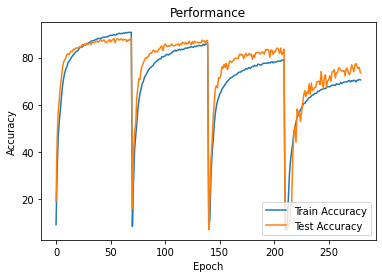

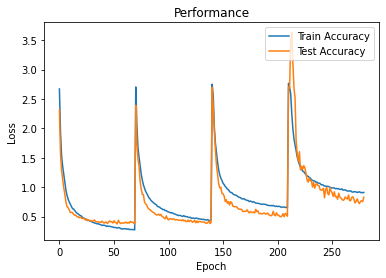

In [ ]:
for d in DROPOUT:

  net = KWS_CNN(drop_out_rate=d).to(device)
  print(net)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE)

  start_epoch=0
  num_epochs=N_EPOCHS

  highest_acc = -1000

  for epoch in range(start_epoch, start_epoch+num_epochs):
      train(net,train_loader,optimizer,criterion,epoch,device)
      best_acc = test(net,val_loader,optimizer,criterion,epoch,device)
      if best_acc > highest_acc:
        highest_acc = best_acc

  ACC_DROPOUT.append(highest_acc)
  plot_performance(ACC_train, ACC_test, LOSS_train, LOSS_test,f"(drop_out={d})")

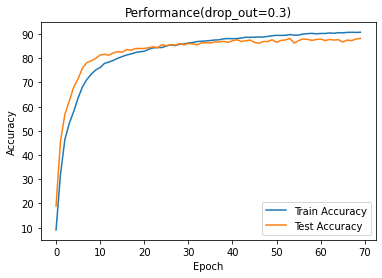

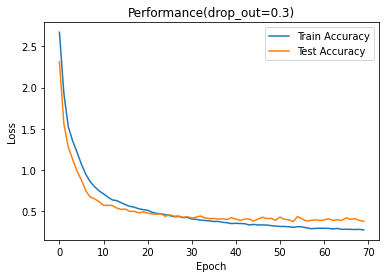

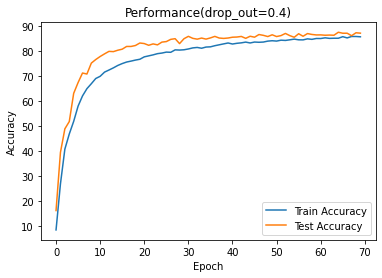

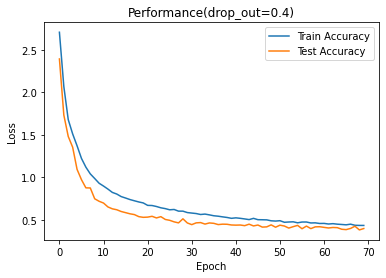

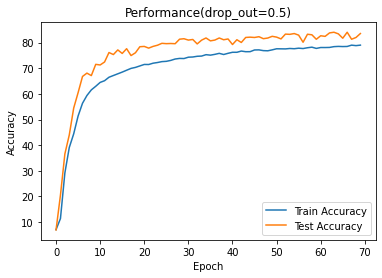

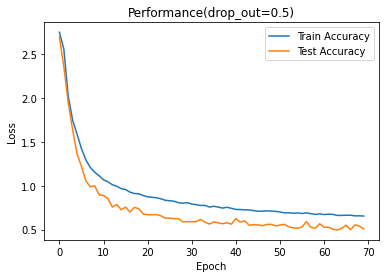

In [ ]:
j = 0
for i in range(70, 281, 70):
  atrain = ACC_train[i-70:i]
  atest = ACC_test[i-70:i]
  ltrain = LOSS_train[i-70:i]
  ltest = LOSS_test[i-70:i]
  plot_performance(atrain, atest, ltrain, ltest, f"(drop_out={d})")
  j += 1

In [ ]:
ACC_DROPOUT = [88.21, 87.45, 84.04,76.94]

[88.21, 88.21, 88.21, 88.21]


# Part 4: Alternative: MFCC Dataloader

In [ ]:
# prepare_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import librosa   #for audio processing
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def load_data(train_audio_path):
    
    labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", 
          "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    # labels = ["zero", "one", "two", "three", "four"]
    #print(labels)

    all_wave = []
    all_label = []
    for label in labels:
        print(label)
        waves = [f for f in os.listdir(train_audio_path + '/'+ label+ '/') if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(samples, sample_rate, 8000)
            
            if(len(samples)== 8000) :                 
                mfcc = librosa.feature.mfcc(samples, sr=8000, n_mfcc=12)
                #print(mfcc.shape)
                
                all_wave.append(mfcc)  # mfcc shape: (12, 16)
                all_label.append(label)

    le = LabelEncoder()
    y=le.fit_transform(all_label)
    classes= list(le.classes_)

    y=np_utils.to_categorical(y, num_classes=len(labels))

    # print(len(all_wave))  # all_wave: (3756, 12, 16)
    # all_wave = np.array(all_wave).reshape(-1,8000,1)
    all_wave = np.array(all_wave).reshape(-1, 12, 16, 1)
    # print(all_wave.shape)
    # print(y.shape)
    return np.array(all_wave), np.array(y)


def get_dataloader(x,y,batch_size=32):
    x = x.transpose(0,3,1,2)
    labels = np.argmax(y,axis=1)

    x_tr, x_val, y_tr, y_val = train_test_split(x,labels,
                            stratify=labels,test_size=0.2,random_state=777,shuffle=True)

    print("Training Data: ",x_tr.shape)
    print("Validating Data: ", x_val.shape)

    features_train = torch.from_numpy(x_tr).float()
    targets_train = torch.from_numpy(y_tr).long()

    features_val = torch.from_numpy(x_val).float()
    targets_val = torch.from_numpy(y_val).long()

    train_set = TensorDataset(features_train,targets_train)
    val_set = TensorDataset(features_val,targets_val)

    train_loader = DataLoader(train_set,batch_size,True)
    val_loader = DataLoader(val_set,batch_size,False)

    print(np.unique(labels))
    
    return train_loader, val_loader

In [ ]:
import torch, argparse
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

    
LEARNING_RATE = 0.001
BATCH_SIZE = 100         
N_EPOCHS = 70           
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
x, y = load_data('gdrive/Shareddrives/CS172B Project/GoogleSpeech/speech_commands_v0.02')
train_loader, val_loader = get_dataloader(x,y,batch_size=BATCH_SIZE)

yes
no
up
down
left
right
on
off
stop
go
zero
one
two
three
four
five
six
seven
eight
nine
Training Data:  (56482, 1, 12, 16)
Validating Data:  (14121, 1, 12, 16)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


# Part 5: New CNN

In [ ]:
# model
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

class KWS_CNN(nn.Module):
    def __init__(self, drop_out_rate=0.3):
        super(KWS_CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=5,stride=1)
        self.dropout1 = nn.Dropout(drop_out_rate) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.dropout2 = nn.Dropout(drop_out_rate)
        
        self.fc1 = nn.Linear(128, 64)
        self.dropout5 = nn.Dropout(drop_out_rate)
        self.fc2 = nn.Linear(64,20)  # 20 is changed adaptive to num_classes
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2)
        x = self.dropout1(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc1(x.reshape(-1,128)))
        x = self.dropout5(x)

        x = self.fc2(x)
        
        return x 

# Part 6: Train & Test

In [ ]:
ACC_train1 = []
ACC_test1 = []
LOSS_train1 = []
LOSS_test1 = []

In [ ]:
# train_config
import torch,os,sys,datetime,time
from tqdm import tqdm
import torch.optim as optim

best_acc=0

def train(net,trainloader,optim,criterion,epoch,device):
    print("Training")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    
    iterator = tqdm(trainloader)
    
    for inputs,targets in iterator:
        
        inputs,targets = inputs.to(device), targets.to(device)
        
        optim.zero_grad()
        outputs = net(inputs)
        # print(targets.shape)
        # print(outputs.shape)
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1,train_loss/len(trainloader),
                                            total_correct*100/total))
    ACC_train1.append(total_correct*100/total)
    LOSS_train1.append(train_loss/len(trainloader))

    
def test(net,testloader,optim,criterion,epoch,device):
    global best_acc
    print("validation")
    net.eval()
    test_loss,total,total_correct = 0,0,0
    
    iterator = tqdm(testloader)
    
    for inputs, targets in iterator:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    # Save checkpoint when best model
    acc = 100. * total_correct / total
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch+1, test_loss, acc))
    ACC_test1.append(acc)
    LOSS_test1.append(test_loss/100)
    

    if acc > best_acc:
        print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        state = {
                'net':net,
                'acc':acc,
                'epoch':epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+'model.t7')
        best_acc = acc
        
    return best_acc

In [ ]:
net = KWS_CNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE)

start_epoch=0
num_epochs=N_EPOCHS

for epoch in range(start_epoch, start_epoch+num_epochs):
    train(net,train_loader,optimizer,criterion,epoch,device)
    best_acc = test(net,val_loader,optimizer,criterion,epoch,device)


Training


100%|██████████| 565/565 [00:03<00:00, 155.75it/s]


Epoch: [1]  loss: [2.74] Accuracy [14.79] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.57it/s]



Validation Epoch #1			Loss: 312.0303 Acc@1: 34.25%
Saving Best model...			Top1 = 34.25%
Training


100%|██████████| 565/565 [00:03<00:00, 158.40it/s]


Epoch: [2]  loss: [2.20] Accuracy [29.25] 
validation


100%|██████████| 142/142 [00:00<00:00, 364.72it/s]



Validation Epoch #2			Loss: 237.4661 Acc@1: 51.50%
Saving Best model...			Top1 = 51.50%
Training


100%|██████████| 565/565 [00:04<00:00, 141.07it/s]


Epoch: [3]  loss: [1.96] Accuracy [36.79] 
validation


100%|██████████| 142/142 [00:00<00:00, 354.11it/s]



Validation Epoch #3			Loss: 206.0925 Acc@1: 56.12%
Saving Best model...			Top1 = 56.12%
Training


100%|██████████| 565/565 [00:04<00:00, 127.38it/s]


Epoch: [4]  loss: [1.85] Accuracy [40.68] 
validation


100%|██████████| 142/142 [00:00<00:00, 158.34it/s]



Validation Epoch #4			Loss: 192.0927 Acc@1: 61.55%
Saving Best model...			Top1 = 61.55%
Training


100%|██████████| 565/565 [00:04<00:00, 124.23it/s]


Epoch: [5]  loss: [1.77] Accuracy [43.29] 
validation


100%|██████████| 142/142 [00:00<00:00, 364.41it/s]



Validation Epoch #5			Loss: 183.7030 Acc@1: 63.44%
Saving Best model...			Top1 = 63.44%
Training


100%|██████████| 565/565 [00:03<00:00, 159.39it/s]


Epoch: [6]  loss: [1.72] Accuracy [44.43] 
validation


100%|██████████| 142/142 [00:00<00:00, 365.27it/s]



Validation Epoch #6			Loss: 172.6285 Acc@1: 64.56%
Saving Best model...			Top1 = 64.56%
Training


100%|██████████| 565/565 [00:03<00:00, 159.79it/s]


Epoch: [7]  loss: [1.69] Accuracy [45.71] 
validation


100%|██████████| 142/142 [00:00<00:00, 358.15it/s]



Validation Epoch #7			Loss: 165.5875 Acc@1: 66.52%
Saving Best model...			Top1 = 66.52%
Training


100%|██████████| 565/565 [00:03<00:00, 146.76it/s]


Epoch: [8]  loss: [1.66] Accuracy [46.68] 
validation


100%|██████████| 142/142 [00:00<00:00, 359.23it/s]



Validation Epoch #8			Loss: 166.7857 Acc@1: 66.85%
Saving Best model...			Top1 = 66.85%
Training


100%|██████████| 565/565 [00:03<00:00, 156.52it/s]


Epoch: [9]  loss: [1.64] Accuracy [47.34] 
validation


100%|██████████| 142/142 [00:00<00:00, 365.69it/s]



Validation Epoch #9			Loss: 162.3793 Acc@1: 68.12%
Saving Best model...			Top1 = 68.12%
Training


100%|██████████| 565/565 [00:03<00:00, 151.84it/s]


Epoch: [10]  loss: [1.61] Accuracy [48.30] 
validation


100%|██████████| 142/142 [00:00<00:00, 365.22it/s]



Validation Epoch #10			Loss: 160.3421 Acc@1: 68.52%
Saving Best model...			Top1 = 68.52%
Training


100%|██████████| 565/565 [00:03<00:00, 157.93it/s]


Epoch: [11]  loss: [1.60] Accuracy [48.85] 
validation


100%|██████████| 142/142 [00:00<00:00, 376.76it/s]



Validation Epoch #11			Loss: 157.4196 Acc@1: 68.00%
Training


100%|██████████| 565/565 [00:03<00:00, 156.46it/s]


Epoch: [12]  loss: [1.58] Accuracy [48.93] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.02it/s]



Validation Epoch #12			Loss: 153.8585 Acc@1: 69.56%
Saving Best model...			Top1 = 69.56%
Training


100%|██████████| 565/565 [00:03<00:00, 156.53it/s]


Epoch: [13]  loss: [1.58] Accuracy [49.62] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.79it/s]



Validation Epoch #13			Loss: 154.0281 Acc@1: 69.67%
Saving Best model...			Top1 = 69.67%
Training


100%|██████████| 565/565 [00:03<00:00, 158.81it/s]


Epoch: [14]  loss: [1.57] Accuracy [49.51] 
validation


100%|██████████| 142/142 [00:00<00:00, 366.08it/s]



Validation Epoch #14			Loss: 153.5138 Acc@1: 70.05%
Saving Best model...			Top1 = 70.05%
Training


100%|██████████| 565/565 [00:03<00:00, 158.38it/s]


Epoch: [15]  loss: [1.56] Accuracy [50.13] 
validation


100%|██████████| 142/142 [00:00<00:00, 371.19it/s]



Validation Epoch #15			Loss: 149.6729 Acc@1: 70.04%
Training


100%|██████████| 565/565 [00:05<00:00, 111.28it/s]


Epoch: [16]  loss: [1.55] Accuracy [50.41] 
validation


100%|██████████| 142/142 [00:00<00:00, 215.08it/s]



Validation Epoch #16			Loss: 149.1501 Acc@1: 70.43%
Saving Best model...			Top1 = 70.43%
Training


100%|██████████| 565/565 [00:06<00:00, 84.00it/s] 


Epoch: [17]  loss: [1.55] Accuracy [50.67] 
validation


100%|██████████| 142/142 [00:00<00:00, 329.43it/s]



Validation Epoch #17			Loss: 148.8071 Acc@1: 70.36%
Training


100%|██████████| 565/565 [00:05<00:00, 112.85it/s]


Epoch: [18]  loss: [1.54] Accuracy [50.61] 
validation


100%|██████████| 142/142 [00:00<00:00, 356.13it/s]



Validation Epoch #18			Loss: 147.9402 Acc@1: 71.11%
Saving Best model...			Top1 = 71.11%
Training


100%|██████████| 565/565 [00:05<00:00, 111.34it/s]


Epoch: [19]  loss: [1.53] Accuracy [50.73] 
validation


100%|██████████| 142/142 [00:00<00:00, 281.67it/s]



Validation Epoch #19			Loss: 142.4256 Acc@1: 71.21%
Saving Best model...			Top1 = 71.21%
Training


100%|██████████| 565/565 [00:04<00:00, 116.91it/s]


Epoch: [20]  loss: [1.53] Accuracy [50.96] 
validation


100%|██████████| 142/142 [00:00<00:00, 232.46it/s]



Validation Epoch #20			Loss: 143.4850 Acc@1: 70.98%
Training


100%|██████████| 565/565 [00:04<00:00, 131.04it/s]


Epoch: [21]  loss: [1.53] Accuracy [51.29] 
validation


100%|██████████| 142/142 [00:00<00:00, 371.70it/s]



Validation Epoch #21			Loss: 142.2925 Acc@1: 71.19%
Training


100%|██████████| 565/565 [00:03<00:00, 159.30it/s]


Epoch: [22]  loss: [1.53] Accuracy [51.09] 
validation


100%|██████████| 142/142 [00:00<00:00, 357.09it/s]



Validation Epoch #22			Loss: 146.0960 Acc@1: 71.06%
Training


100%|██████████| 565/565 [00:03<00:00, 157.29it/s]


Epoch: [23]  loss: [1.51] Accuracy [51.83] 
validation


100%|██████████| 142/142 [00:00<00:00, 358.83it/s]



Validation Epoch #23			Loss: 143.2149 Acc@1: 70.76%
Training


100%|██████████| 565/565 [00:03<00:00, 155.99it/s]


Epoch: [24]  loss: [1.51] Accuracy [51.54] 
validation


100%|██████████| 142/142 [00:00<00:00, 373.86it/s]



Validation Epoch #24			Loss: 145.8094 Acc@1: 70.73%
Training


100%|██████████| 565/565 [00:03<00:00, 159.89it/s]


Epoch: [25]  loss: [1.51] Accuracy [51.71] 
validation


100%|██████████| 142/142 [00:00<00:00, 392.72it/s]



Validation Epoch #25			Loss: 143.4323 Acc@1: 71.01%
Training


100%|██████████| 565/565 [00:04<00:00, 113.59it/s]


Epoch: [26]  loss: [1.52] Accuracy [51.65] 
validation


100%|██████████| 142/142 [00:00<00:00, 248.12it/s]



Validation Epoch #26			Loss: 139.6263 Acc@1: 71.59%
Saving Best model...			Top1 = 71.59%
Training


100%|██████████| 565/565 [00:03<00:00, 154.97it/s]


Epoch: [27]  loss: [1.50] Accuracy [52.01] 
validation


100%|██████████| 142/142 [00:00<00:00, 205.78it/s]



Validation Epoch #27			Loss: 139.3912 Acc@1: 72.22%
Saving Best model...			Top1 = 72.22%
Training


100%|██████████| 565/565 [00:04<00:00, 136.14it/s]


Epoch: [28]  loss: [1.50] Accuracy [51.97] 
validation


100%|██████████| 142/142 [00:00<00:00, 353.32it/s]



Validation Epoch #28			Loss: 139.7289 Acc@1: 71.61%
Training


100%|██████████| 565/565 [00:03<00:00, 156.06it/s]


Epoch: [29]  loss: [1.50] Accuracy [52.09] 
validation


100%|██████████| 142/142 [00:00<00:00, 360.28it/s]



Validation Epoch #29			Loss: 141.2172 Acc@1: 71.57%
Training


100%|██████████| 565/565 [00:03<00:00, 156.95it/s]


Epoch: [30]  loss: [1.50] Accuracy [52.13] 
validation


100%|██████████| 142/142 [00:00<00:00, 359.90it/s]



Validation Epoch #30			Loss: 137.7119 Acc@1: 71.96%
Training


100%|██████████| 565/565 [00:03<00:00, 156.15it/s]


Epoch: [31]  loss: [1.50] Accuracy [52.37] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.53it/s]



Validation Epoch #31			Loss: 141.5186 Acc@1: 71.26%
Training


100%|██████████| 565/565 [00:07<00:00, 70.67it/s]


Epoch: [32]  loss: [1.49] Accuracy [52.48] 
validation


100%|██████████| 142/142 [00:00<00:00, 359.76it/s]



Validation Epoch #32			Loss: 139.6547 Acc@1: 72.19%
Training


100%|██████████| 565/565 [00:03<00:00, 155.22it/s]


Epoch: [33]  loss: [1.49] Accuracy [52.66] 
validation


100%|██████████| 142/142 [00:00<00:00, 369.25it/s]



Validation Epoch #33			Loss: 136.1533 Acc@1: 72.25%
Saving Best model...			Top1 = 72.25%
Training


100%|██████████| 565/565 [00:03<00:00, 161.42it/s]


Epoch: [34]  loss: [1.49] Accuracy [52.61] 
validation


100%|██████████| 142/142 [00:00<00:00, 365.33it/s]



Validation Epoch #34			Loss: 142.1788 Acc@1: 71.35%
Training


100%|██████████| 565/565 [00:03<00:00, 158.88it/s]


Epoch: [35]  loss: [1.50] Accuracy [52.45] 
validation


100%|██████████| 142/142 [00:00<00:00, 378.51it/s]



Validation Epoch #35			Loss: 139.5996 Acc@1: 71.52%
Training


100%|██████████| 565/565 [00:03<00:00, 163.21it/s]


Epoch: [36]  loss: [1.48] Accuracy [52.55] 
validation


100%|██████████| 142/142 [00:00<00:00, 372.42it/s]



Validation Epoch #36			Loss: 138.5423 Acc@1: 72.08%
Training


100%|██████████| 565/565 [00:03<00:00, 164.34it/s]


Epoch: [37]  loss: [1.49] Accuracy [52.17] 
validation


100%|██████████| 142/142 [00:00<00:00, 375.22it/s]



Validation Epoch #37			Loss: 136.5670 Acc@1: 72.33%
Saving Best model...			Top1 = 72.33%
Training


100%|██████████| 565/565 [00:03<00:00, 158.36it/s]


Epoch: [38]  loss: [1.49] Accuracy [52.38] 
validation


100%|██████████| 142/142 [00:00<00:00, 358.83it/s]



Validation Epoch #38			Loss: 138.4423 Acc@1: 71.43%
Training


100%|██████████| 565/565 [00:03<00:00, 158.82it/s]


Epoch: [39]  loss: [1.49] Accuracy [52.47] 
validation


100%|██████████| 142/142 [00:00<00:00, 376.40it/s]



Validation Epoch #39			Loss: 136.5532 Acc@1: 71.84%
Training


100%|██████████| 565/565 [00:03<00:00, 158.39it/s]


Epoch: [40]  loss: [1.48] Accuracy [53.04] 
validation


100%|██████████| 142/142 [00:00<00:00, 373.10it/s]



Validation Epoch #40			Loss: 134.8053 Acc@1: 71.89%
Training


100%|██████████| 565/565 [00:03<00:00, 155.94it/s]


Epoch: [41]  loss: [1.48] Accuracy [52.96] 
validation


100%|██████████| 142/142 [00:00<00:00, 370.55it/s]



Validation Epoch #41			Loss: 136.1332 Acc@1: 72.66%
Saving Best model...			Top1 = 72.66%
Training


100%|██████████| 565/565 [00:03<00:00, 156.65it/s]


Epoch: [42]  loss: [1.48] Accuracy [52.47] 
validation


100%|██████████| 142/142 [00:00<00:00, 354.35it/s]



Validation Epoch #42			Loss: 135.1828 Acc@1: 71.88%
Training


100%|██████████| 565/565 [00:03<00:00, 157.04it/s]


Epoch: [43]  loss: [1.47] Accuracy [53.05] 
validation


100%|██████████| 142/142 [00:00<00:00, 381.14it/s]



Validation Epoch #43			Loss: 136.3452 Acc@1: 72.26%
Training


100%|██████████| 565/565 [00:03<00:00, 159.63it/s]


Epoch: [44]  loss: [1.47] Accuracy [52.97] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.40it/s]



Validation Epoch #44			Loss: 134.6379 Acc@1: 72.18%
Training


100%|██████████| 565/565 [00:03<00:00, 155.04it/s]


Epoch: [45]  loss: [1.47] Accuracy [52.92] 
validation


100%|██████████| 142/142 [00:00<00:00, 330.79it/s]



Validation Epoch #45			Loss: 137.6150 Acc@1: 71.89%
Training


100%|██████████| 565/565 [00:03<00:00, 162.48it/s]


Epoch: [46]  loss: [1.47] Accuracy [52.93] 
validation


100%|██████████| 142/142 [00:00<00:00, 384.52it/s]



Validation Epoch #46			Loss: 137.6953 Acc@1: 71.70%
Training


100%|██████████| 565/565 [00:03<00:00, 160.61it/s]


Epoch: [47]  loss: [1.48] Accuracy [52.85] 
validation


100%|██████████| 142/142 [00:00<00:00, 354.21it/s]



Validation Epoch #47			Loss: 137.0542 Acc@1: 72.65%
Training


100%|██████████| 565/565 [00:03<00:00, 155.61it/s]


Epoch: [48]  loss: [1.48] Accuracy [52.92] 
validation


100%|██████████| 142/142 [00:00<00:00, 352.57it/s]



Validation Epoch #48			Loss: 136.7535 Acc@1: 71.72%
Training


100%|██████████| 565/565 [00:03<00:00, 153.17it/s]


Epoch: [49]  loss: [1.47] Accuracy [53.00] 
validation


100%|██████████| 142/142 [00:00<00:00, 376.83it/s]



Validation Epoch #49			Loss: 136.8625 Acc@1: 71.85%
Training


100%|██████████| 565/565 [00:03<00:00, 157.47it/s]


Epoch: [50]  loss: [1.47] Accuracy [53.15] 
validation


100%|██████████| 142/142 [00:00<00:00, 358.51it/s]



Validation Epoch #50			Loss: 133.7703 Acc@1: 72.46%
Training


100%|██████████| 565/565 [00:03<00:00, 157.17it/s]


Epoch: [51]  loss: [1.46] Accuracy [53.26] 
validation


100%|██████████| 142/142 [00:00<00:00, 361.93it/s]



Validation Epoch #51			Loss: 137.4248 Acc@1: 71.69%
Training


100%|██████████| 565/565 [00:04<00:00, 138.59it/s]


Epoch: [52]  loss: [1.47] Accuracy [53.20] 
validation


100%|██████████| 142/142 [00:00<00:00, 243.25it/s]



Validation Epoch #52			Loss: 135.4890 Acc@1: 71.87%
Training


100%|██████████| 565/565 [00:05<00:00, 103.47it/s]


Epoch: [53]  loss: [1.47] Accuracy [53.07] 
validation


100%|██████████| 142/142 [00:00<00:00, 316.80it/s]



Validation Epoch #53			Loss: 134.3771 Acc@1: 72.30%
Training


100%|██████████| 565/565 [00:03<00:00, 146.50it/s]


Epoch: [54]  loss: [1.47] Accuracy [52.95] 
validation


100%|██████████| 142/142 [00:00<00:00, 355.83it/s]



Validation Epoch #54			Loss: 138.6767 Acc@1: 71.27%
Training


100%|██████████| 565/565 [00:03<00:00, 154.02it/s]


Epoch: [55]  loss: [1.47] Accuracy [53.28] 
validation


100%|██████████| 142/142 [00:00<00:00, 369.97it/s]



Validation Epoch #55			Loss: 133.0531 Acc@1: 72.31%
Training


100%|██████████| 565/565 [00:03<00:00, 156.18it/s]


Epoch: [56]  loss: [1.47] Accuracy [53.09] 
validation


100%|██████████| 142/142 [00:00<00:00, 327.82it/s]



Validation Epoch #56			Loss: 136.4347 Acc@1: 71.27%
Training


100%|██████████| 565/565 [00:03<00:00, 149.16it/s]


Epoch: [57]  loss: [1.46] Accuracy [53.14] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.25it/s]



Validation Epoch #57			Loss: 134.8841 Acc@1: 72.51%
Training


100%|██████████| 565/565 [00:03<00:00, 147.02it/s]


Epoch: [58]  loss: [1.46] Accuracy [53.45] 
validation


100%|██████████| 142/142 [00:00<00:00, 335.22it/s]



Validation Epoch #58			Loss: 135.7128 Acc@1: 72.20%
Training


100%|██████████| 565/565 [00:03<00:00, 155.17it/s]


Epoch: [59]  loss: [1.47] Accuracy [53.00] 
validation


100%|██████████| 142/142 [00:00<00:00, 358.01it/s]



Validation Epoch #59			Loss: 132.6173 Acc@1: 72.71%
Saving Best model...			Top1 = 72.71%
Training


100%|██████████| 565/565 [00:03<00:00, 160.04it/s]


Epoch: [60]  loss: [1.47] Accuracy [53.24] 
validation


100%|██████████| 142/142 [00:00<00:00, 373.31it/s]



Validation Epoch #60			Loss: 137.7070 Acc@1: 71.63%
Training


100%|██████████| 565/565 [00:03<00:00, 159.67it/s]


Epoch: [61]  loss: [1.46] Accuracy [53.32] 
validation


100%|██████████| 142/142 [00:00<00:00, 344.45it/s]



Validation Epoch #61			Loss: 135.7031 Acc@1: 71.85%
Training


100%|██████████| 565/565 [00:03<00:00, 155.98it/s]


Epoch: [62]  loss: [1.46] Accuracy [53.31] 
validation


100%|██████████| 142/142 [00:00<00:00, 347.29it/s]



Validation Epoch #62			Loss: 137.9974 Acc@1: 71.71%
Training


100%|██████████| 565/565 [00:03<00:00, 155.90it/s]


Epoch: [63]  loss: [1.46] Accuracy [53.33] 
validation


100%|██████████| 142/142 [00:00<00:00, 354.12it/s]



Validation Epoch #63			Loss: 134.9943 Acc@1: 72.69%
Training


100%|██████████| 565/565 [00:03<00:00, 150.73it/s]


Epoch: [64]  loss: [1.46] Accuracy [53.34] 
validation


100%|██████████| 142/142 [00:00<00:00, 338.32it/s]



Validation Epoch #64			Loss: 136.0946 Acc@1: 72.09%
Training


100%|██████████| 565/565 [00:03<00:00, 161.96it/s]


Epoch: [65]  loss: [1.46] Accuracy [53.33] 
validation


100%|██████████| 142/142 [00:00<00:00, 376.44it/s]



Validation Epoch #65			Loss: 136.2133 Acc@1: 72.67%
Training


100%|██████████| 565/565 [00:03<00:00, 166.81it/s]


Epoch: [66]  loss: [1.46] Accuracy [53.38] 
validation


100%|██████████| 142/142 [00:00<00:00, 371.37it/s]



Validation Epoch #66			Loss: 135.7133 Acc@1: 71.86%
Training


100%|██████████| 565/565 [00:03<00:00, 156.45it/s]


Epoch: [67]  loss: [1.46] Accuracy [53.32] 
validation


100%|██████████| 142/142 [00:00<00:00, 363.46it/s]



Validation Epoch #67			Loss: 138.0573 Acc@1: 71.56%
Training


100%|██████████| 565/565 [00:03<00:00, 159.55it/s]


Epoch: [68]  loss: [1.46] Accuracy [53.62] 
validation


100%|██████████| 142/142 [00:00<00:00, 333.32it/s]



Validation Epoch #68			Loss: 134.4681 Acc@1: 72.28%
Training


100%|██████████| 565/565 [00:03<00:00, 154.61it/s]


Epoch: [69]  loss: [1.45] Accuracy [53.71] 
validation


100%|██████████| 142/142 [00:00<00:00, 364.30it/s]



Validation Epoch #69			Loss: 134.8259 Acc@1: 73.02%
Saving Best model...			Top1 = 73.02%
Training


100%|██████████| 565/565 [00:03<00:00, 158.11it/s]


Epoch: [70]  loss: [1.46] Accuracy [53.40] 
validation


100%|██████████| 142/142 [00:00<00:00, 354.35it/s]



Validation Epoch #70			Loss: 135.6480 Acc@1: 72.94%


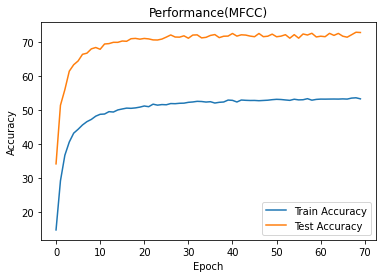

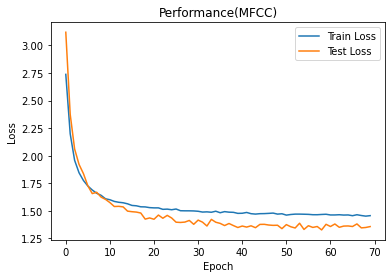

In [ ]:
plot_performance(ACC_train1, ACC_test1, LOSS_train1, LOSS_test1, "(MFCC)")